In [1]:
from neuron_model import dyns, neuron, network,e_dyns,exp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from typing import List
import pickle
from numba import jit,njit,typeof
from numba.typed import List as NumbaList

#mis=(np.random.rand(12,2)*0.2-0.1)+1.0
mis=np.array([[0.92609936, 1.04030251],
 [1.08990199, 0.96314537],
 [0.95855323, 1.04500793],
 [0.94757596, 1.07437747],
 [1.04912963, 1.09813075],
 [0.97847925, 0.94515563],
 [1.08024781, 1.02569354],
 [1.02212363, 0.99312849],
 [1.09042846, 1.09455804],
 [1.04422248, 1.05700935],
 [0.91937835, 1.00623917],
 [0.95225629, 1.04815975]])
#mis_t=(np.random.rand(12,4)*0.01-0.005)*2+1.0
mis_t=np.array([[1.00624955, 1.00653017, 0.99632439, 1.00371368],
 [0.99696342, 0.992745,   0.99533094, 0.9936827 ],
 [1.00657543, 0.99577595, 1.00797668, 1.0082202 ],
 [0.9968211,  1.00796824, 1.00832337, 0.9922949 ],
 [1.00940513, 0.99072558, 0.99883522, 0.99657906],
 [0.99210138, 0.99354303, 1.00782988, 1.00993412],
 [1.00346248, 1.00776864, 1.0050221,  1.0009537 ],
 [0.99122363, 1.007003,   1.00363552, 0.99600824],
 [1.00503467, 0.99437215, 0.99785033, 0.99007775],
 [1.00216428, 0.99226534, 1.00489528, 0.99316654],
 [1.00536349, 0.99371844, 0.99261024, 0.99874712],
 [0.99540985, 1.00244202, 1.00577586, 1.00434942]])
print(mis)
print(mis_t)
# generate internal dynamics with mismatches for robustness simulation
dyns_time=dyns(mis,mis_t,True,False)
dyns_act=dyns(mis,mis_t,False,True)
dyns_time_act=dyns(mis,mis_t,True,True)

[[0.92609936 1.04030251]
 [1.08990199 0.96314537]
 [0.95855323 1.04500793]
 [0.94757596 1.07437747]
 [1.04912963 1.09813075]
 [0.97847925 0.94515563]
 [1.08024781 1.02569354]
 [1.02212363 0.99312849]
 [1.09042846 1.09455804]
 [1.04422248 1.05700935]
 [0.91937835 1.00623917]
 [0.95225629 1.04815975]]
[[1.00624955 1.00653017 0.99632439 1.00371368]
 [0.99696342 0.992745   0.99533094 0.9936827 ]
 [1.00657543 0.99577595 1.00797668 1.0082202 ]
 [0.9968211  1.00796824 1.00832337 0.9922949 ]
 [1.00940513 0.99072558 0.99883522 0.99657906]
 [0.99210138 0.99354303 1.00782988 1.00993412]
 [1.00346248 1.00776864 1.0050221  1.0009537 ]
 [0.99122363 1.007003   1.00363552 0.99600824]
 [1.00503467 0.99437215 0.99785033 0.99007775]
 [1.00216428 0.99226534 1.00489528 0.99316654]
 [1.00536349 0.99371844 0.99261024 0.99874712]
 [0.99540985 1.00244202 1.00577586 1.00434942]]


In [3]:
ones=np.ones 
# Model parameters (global)
VNa = 50
VK = -80
VCa = 80
VH = -20
Vleak = -50
VSyn = -75
taus = 10.
C = 1.
taumean=30.

# Model parameters (mean)
Iappvec = 0.*ones(5)

Iappvec = 0.*ones(5) + 0/2*(np.random.rand(5)-0.5)
kcvec = 0.94*ones(5)
KdCavec = 3.*ones(5)

gleakvec = 0.01*ones(5)

gNavec = [652.814,503.58,634.723,459.807,616.433]
gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574]
gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102]
gAvec = [51.5008,58.3269,40.3572,58.5102,51.8502]
gKdvec = [109.659,84.1655,74.7833,91.1938,111.87]
gKCavec = [63.0373,54.1351,65.7822,55.9324,70.2168]
gHvec = [0.107445,0.0929811,0.078182,0.083414,0.0887343]
tmKCavec = [3.93883,3.24514,5.55055,12.6351,16.6223]

gsyn12 = 0.07635083670743605
gsyn13 = 0.07988922275521991
gsyn21 = 0.07716951193265496
gsyn45 = 0.07762158408977728
gsyn53 = .08835472319081544
gsyn54 = 0.11712333284581126
gEl23 = 0.021083916923133217
gEl43 = 0.022874860313218278

@jit
def sigmoid(x,tau):
    return 1/(1+exp(-tau*x))

#neural modulation schemes
@jit
def fgS(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]


@jit
def fgS2(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT2(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]

@jit
def fgS3(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[15000,8500]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT3(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[15000,8500]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]
import copy

# STG network generators 
def random_MOD_mis(MOD,mis_time=False,mis_act=False): # use V only observer
  
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    
    if (mis_time and mis_act):# define interal dynamics model of the observer (with mismatches or not)
        e_dyns2=dyns_time_act
    elif mis_time:
        e_dyns2=dyns_time
    elif mis_act:
        e_dyns2=dyns_act
    else:
        e_dyns2=e_dyns
    
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
             e_dyns,e_dyns2,ob_type='V'
        ))# initialised cells in the STG network
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    # defined network topology (two types of connections, each defined by a matrix)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis2(MOD,mis_time=False,mis_act=False):# use V and Ca input observer

    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    
    if (mis_time and mis_act):
        e_dyns2=dyns_time_act
    elif mis_time:
        e_dyns2=dyns_time
    elif mis_act:
        e_dyns2=dyns_act
    else:
        e_dyns2=e_dyns
        
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
           e_dyns,e_dyns2,ob_type='V_Ca'
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis3(MOD,mis_time=False,mis_act=False):# Ca based observer
  
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    
    if (mis_time and mis_act):
        e_dyns2=dyns_time_act
    elif mis_time:
        e_dyns2=dyns_time
    elif mis_act:
        e_dyns2=dyns_act
    else:
        e_dyns2=e_dyns
        
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
             e_dyns,e_dyns2,ob_type='Ca'
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def inti_cond_net(net1):
    return [*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]

def inti_cond_net_mis(net1):
    return [*net1.cells[0].init_cond_OB_mis(-60+5),*net1.cells[1].init_cond_OB_mis(-60-5),*net1.cells[2].init_cond_OB_mis(-61),*net1.cells[3].init_cond_OB_mis(-60-2),*net1.cells[4].init_cond_OB_mis(-60+1)]

def inti_cond_net_0(net1):
    return [*net1.cells[0].init_cond_OB_0(-60+5),*net1.cells[1].init_cond_OB_0(-60-5),*net1.cells[2].init_cond_OB_0(-61),*net1.cells[3].init_cond_OB_0(-60-2),*net1.cells[4].init_cond_OB_0(-60+1)]


In [4]:
#ploting functions
def plot_fun(net1,sol5,origin=0):
    T_plot=10000
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[0][T_plot:], label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys][T_plot:] ,label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun1(net1,sol5,origin=0):
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t-origin, sol5.y[12], label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+12] ,label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun2(net1,sol5,fgS_=fgS,fgT_=fgT,origin=0):
    fgS_array=[[fgS_(j,i) for i in sol5.t]for j in range(5)]
    fgT_array=[[fgT_(j,i) for i in sol5.t]for j in range(5)]
    
    fig=plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    T_plot=30000
    plt.rc('xtick', labelsize=16)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[0][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[0][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_dinamics+2][T_plot:], label='observer gT')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_dinamics+7][T_plot:], label='observer gS')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[1][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[1][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][T_plot:] ,label='observer gT')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+7][T_plot:] ,label='observer gS')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[2][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[2][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][T_plot:],label='observer gT')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+7][T_plot:],label='observer gS')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[3][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[3][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][T_plot:],label='observer gT')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+7][T_plot:],label='observer gS')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[4][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[4][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][T_plot:],label='observer gT')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+7][T_plot:],label='observer gS')
    plt.legend(prop={"size":25})
    plt.show()
    print(sol5.y[net1.cells[0].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][-1])
    return fig
    
def plot_fun3(net1,sol5,origin=0):

    labels=[ 'Na','H','T','A','Kd','leak','KCa','S','syn1','syn2','syn3','syn4']
    
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    T_plot=30000
    
    for i in range(net1.cells[0].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 2)
    for i in range(net1.cells[1].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 3)
    for i in range(net1.cells[2].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 4)
    for i in range(net1.cells[3].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 5)
    for i in range(net1.cells[4].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.show()    

## STG simulations

#### example : STG with V only observer (no mismatches)

In [70]:
net8=random_MOD_mis([0.,1.,1.,1.,0.],False,False)
# set hyper parameters for adaptive observer
gamma=10.
alpha=0.001
# set neuromodulation scheme for STG
net8.set_mod(fgS,fgT)
# specify parameters to learn (all in this case)
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.]) # cells with one synapse 
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]) # cells with two synapes
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])# cells with four synapes
net8.cells[0].set_hyp(gamma,alpha,variable_mask1)
net8.cells[1].set_hyp(gamma,alpha,variable_mask2)
net8.cells[2].set_hyp(gamma,alpha,variable_mask3)
net8.cells[3].set_hyp(gamma,alpha,variable_mask2)
net8.cells[4].set_hyp(gamma,alpha,variable_mask1)
# get initial condition 
X0=inti_cond_net(net8)
# set simulation time
Tfinal=28000.0
tspan=[0.0,Tfinal]
# start simulation and the timer 
start = time.time()
sol8=solve_ivp(net8.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[12.68155835 76.55224814 15.0826566  38.12567734 48.68145415 54.42160548
 47.51883208 20.51584233 36.09982139]
[-62.60001938]
[ 9.64632783 57.61772605 58.02228358 64.70363749 59.95442163 44.60012963
 55.57708372 75.27377444 81.97789474 11.21879897]
[-34.25022143]
[24.61898161  6.72161235 57.51581595 23.21633471 53.98449061 83.20853068
 21.47855474 18.3457314  11.60940103 74.90090621 10.64314973 88.82035615]
[-79.17711942]
[16.91275611 53.1282421  36.40281979 45.20858795 56.58733769  7.82864604
 38.9615317  41.84929423 52.10078514 69.40447912]
[-39.65322181]
[9.31269664e+01 3.12819052e+01 2.81667418e+01 3.40643279e-02
 1.33016594e+01 6.86160804e+01 9.78149222e+00 8.93670444e+01
 4.78417307e+01]
[-9

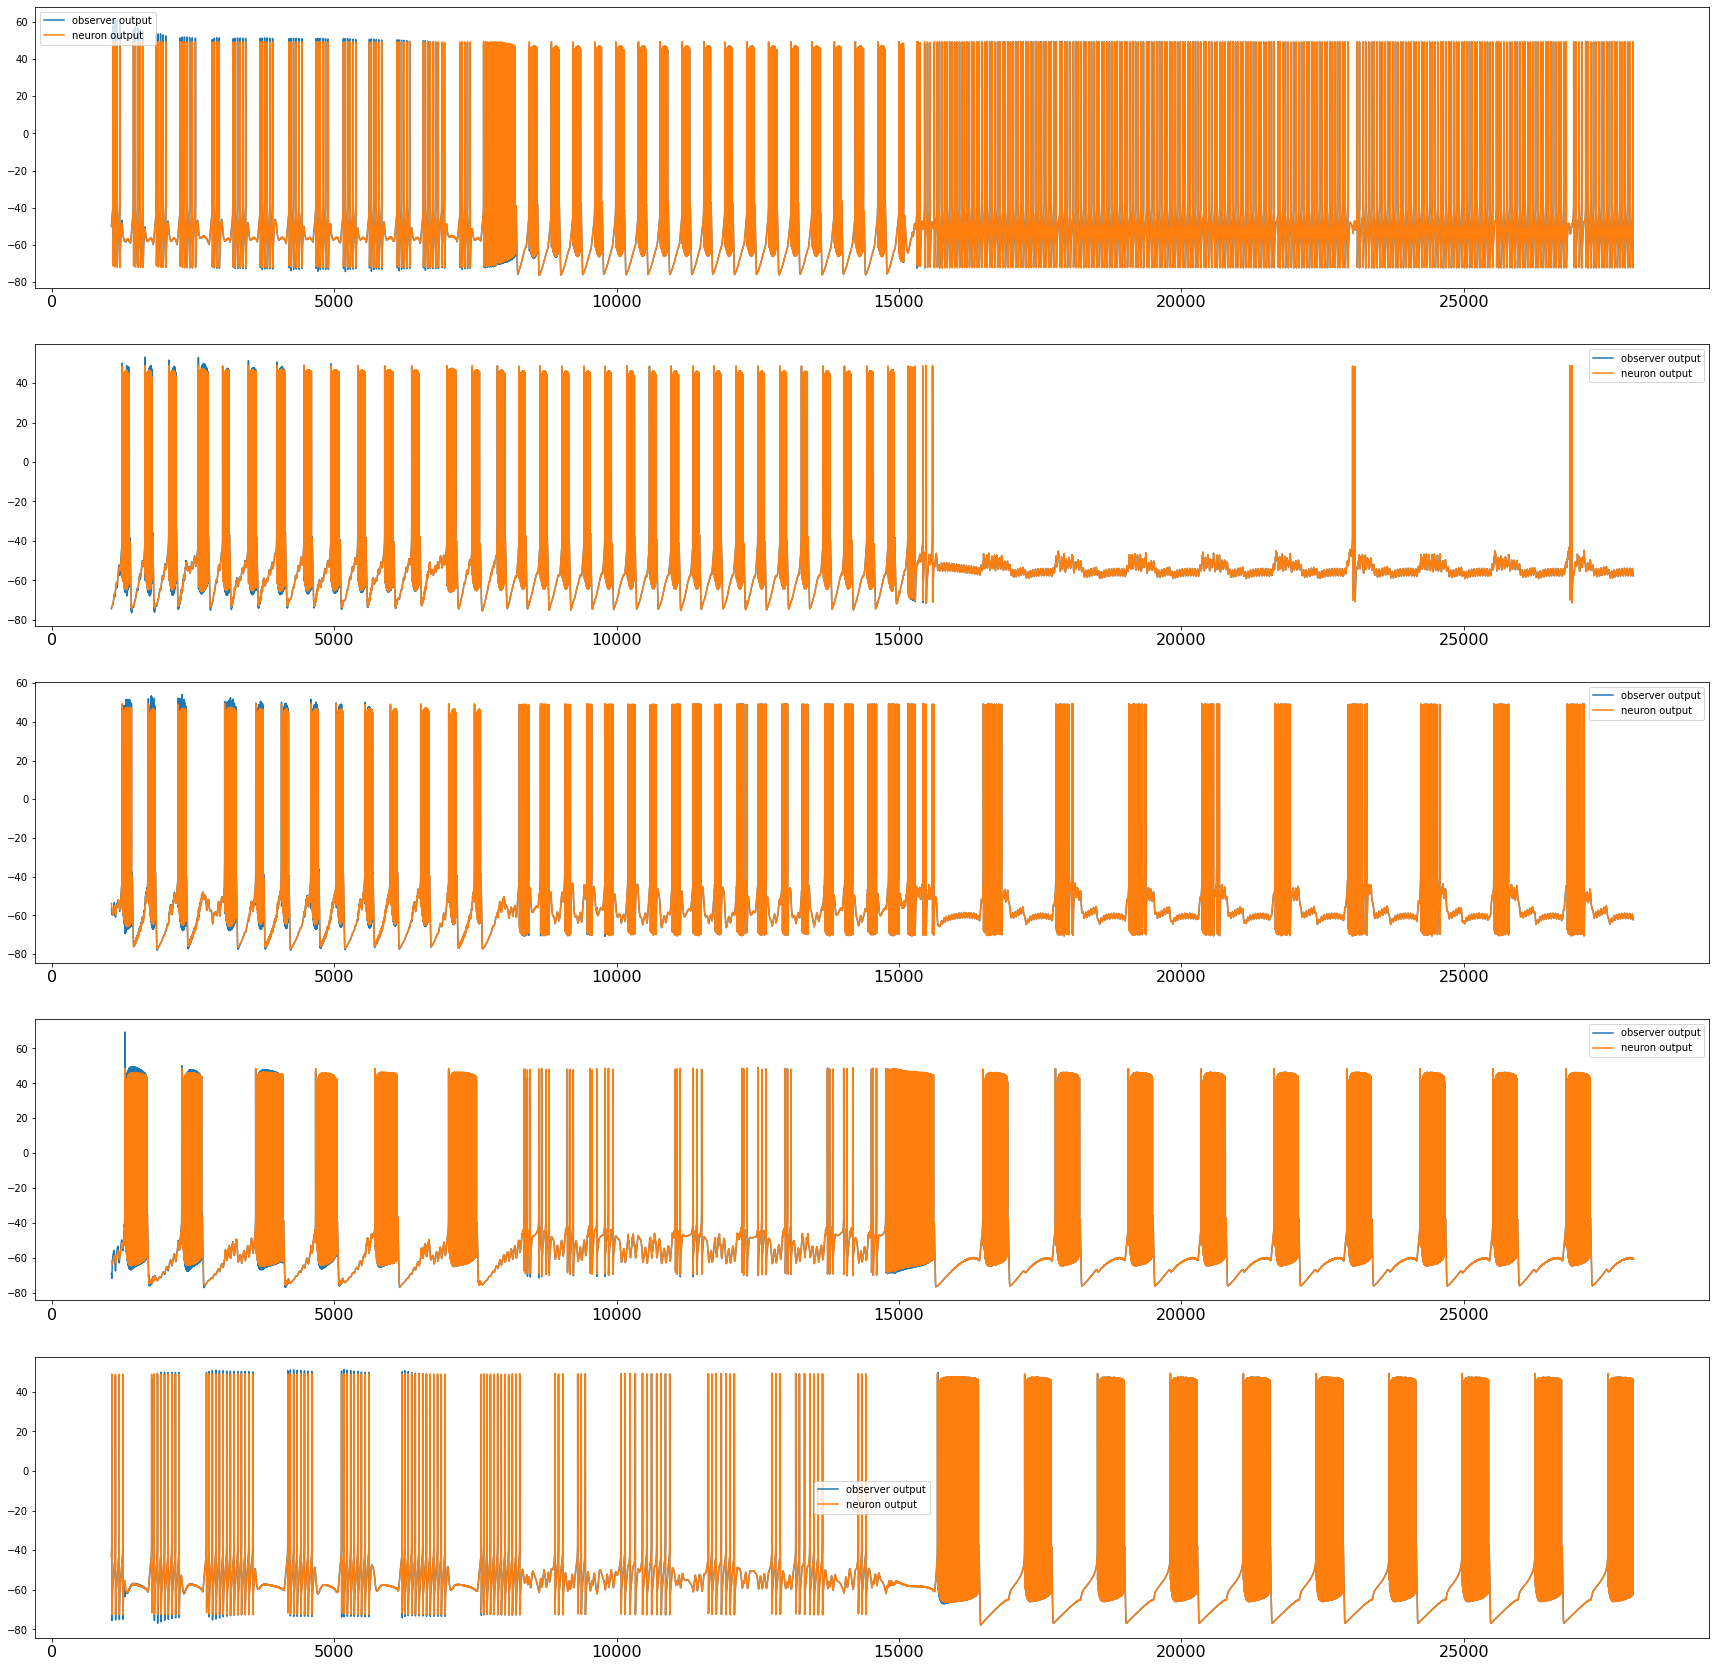

In [71]:
plot_fun(net8,sol8)

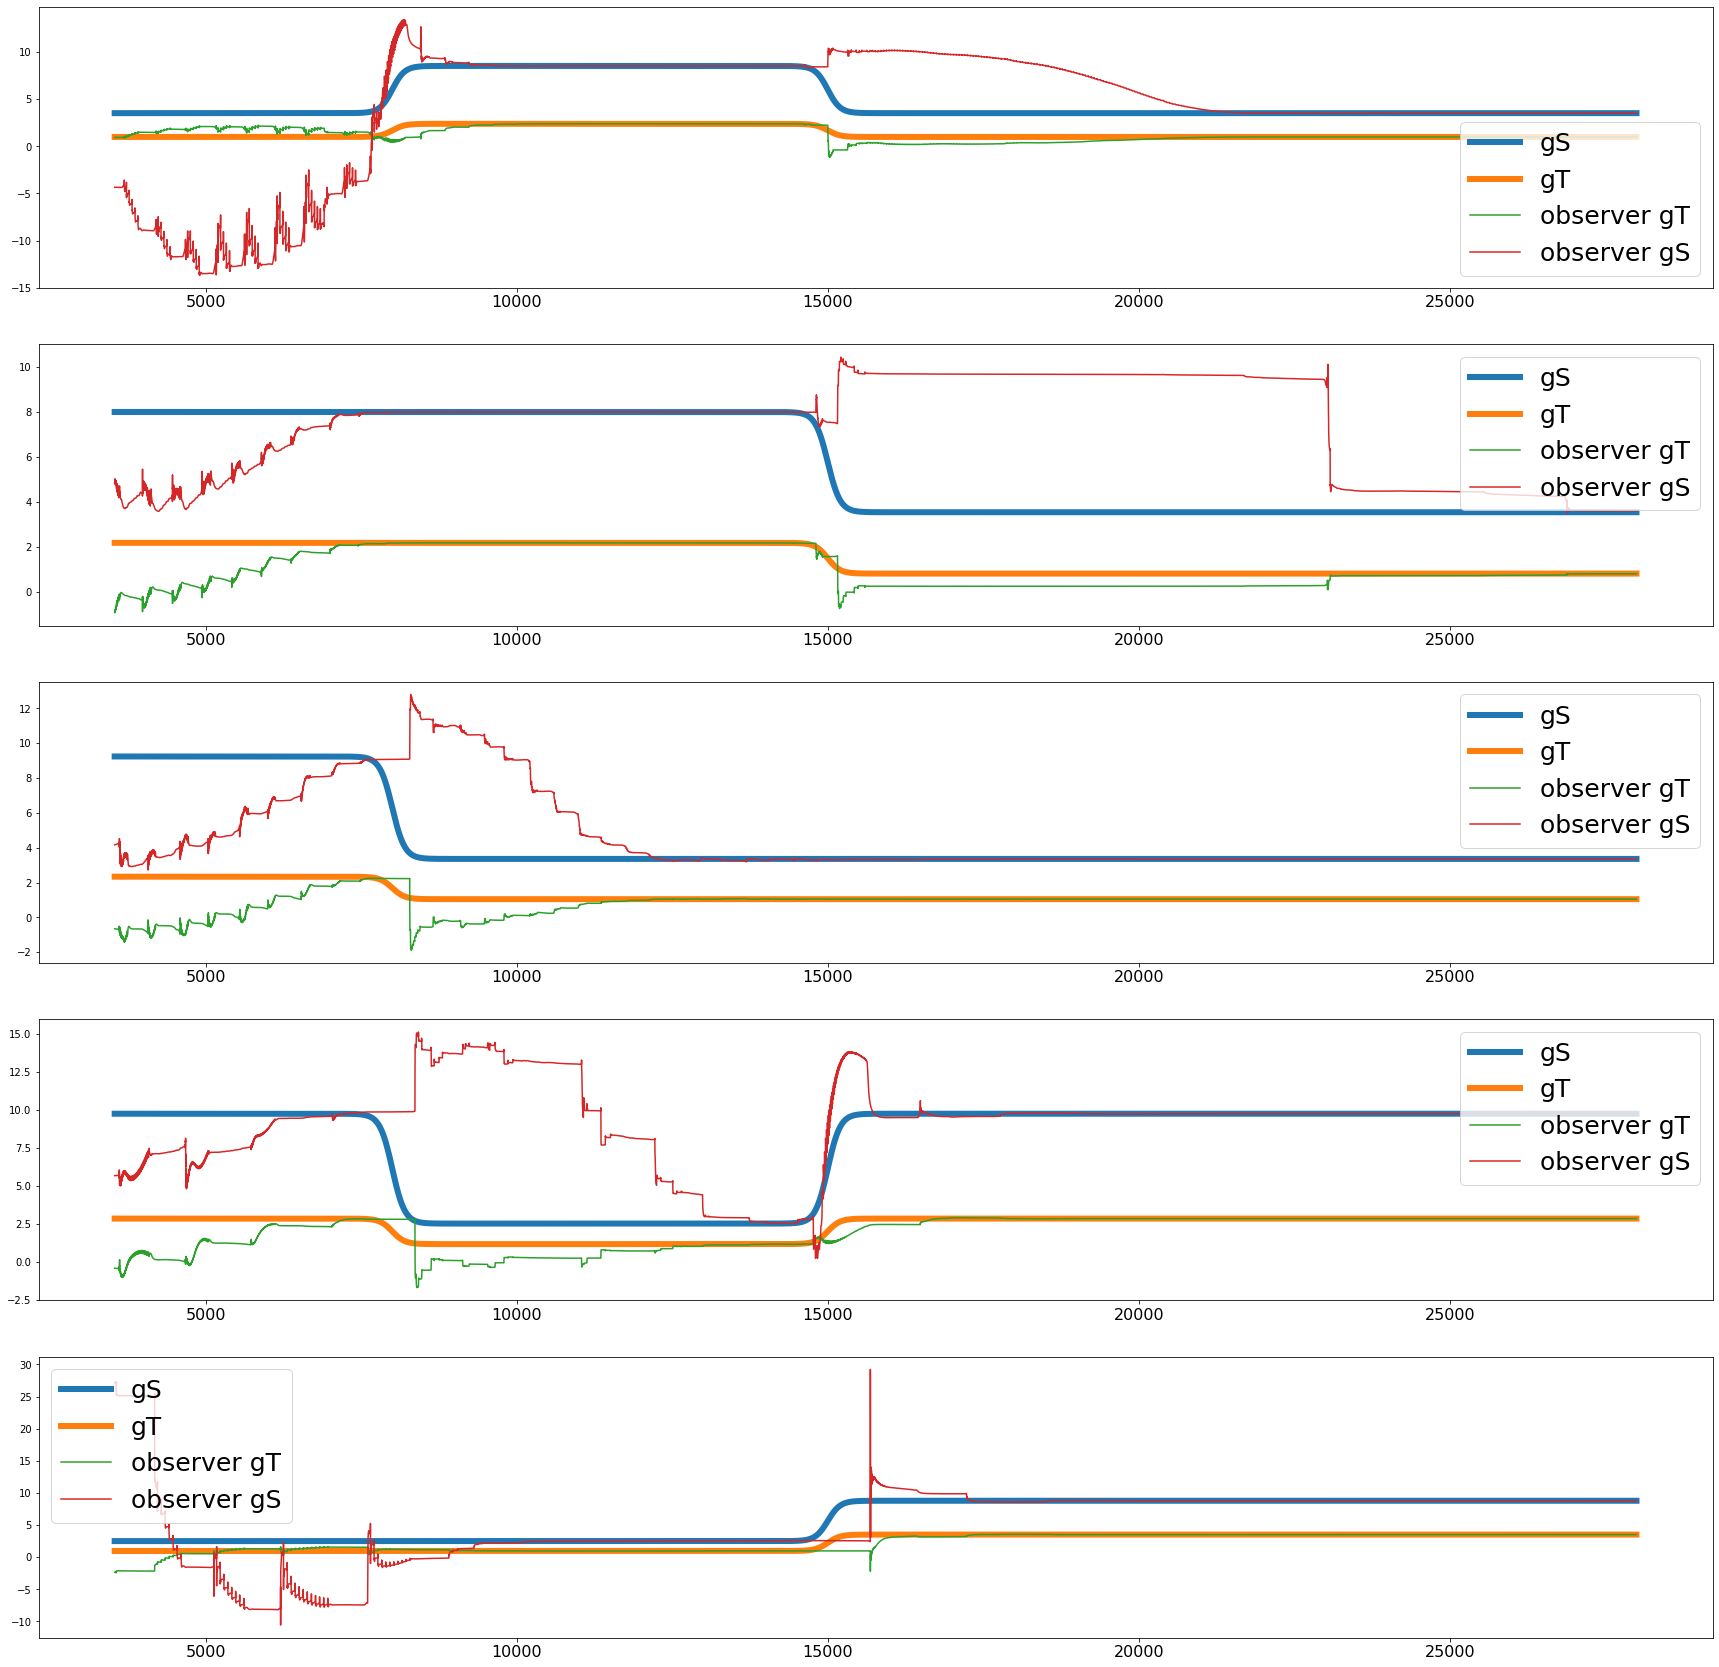

0.9941447457631021
0.8156344523787952
1.049579999996349
2.8295700183952164
3.5257399605533974


In [74]:
fig=plot_fun2(net8,sol8,fgS,fgT,origin=0)

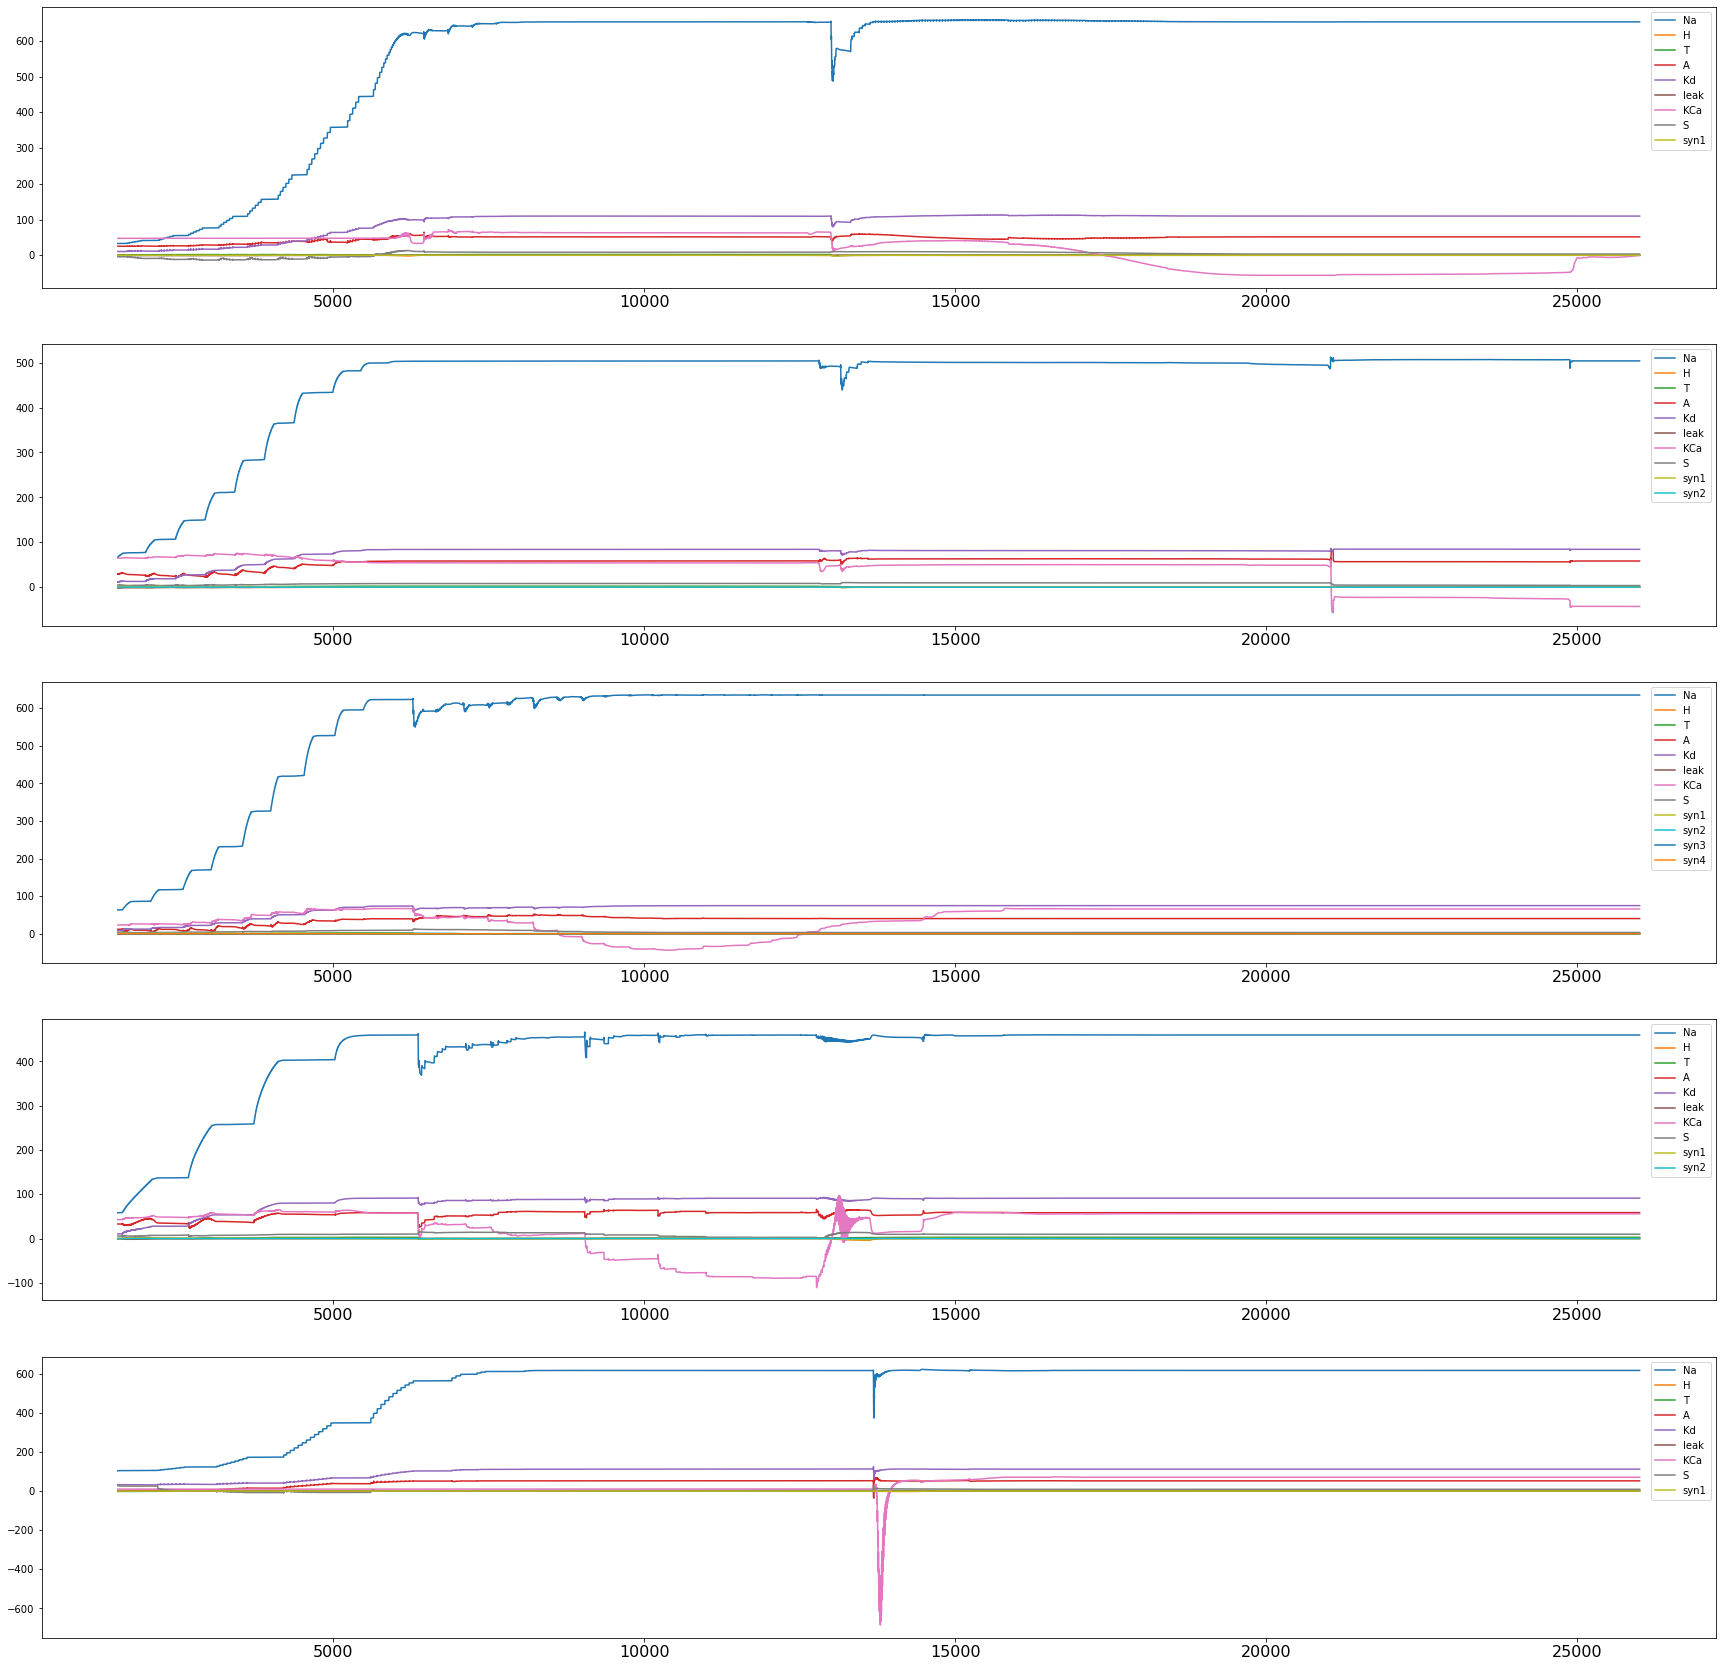

In [73]:
plot_fun3(net8,sol8,origin=2000)

#### example simulating STG only

In [ ]:
# get initial condition 
X0=inti_cond_net(net8)
# set simulation time
Tfinal=28000.0
tspan=[0.0,Tfinal]
# start simulation and the timer 
start = time.time()
sol9=solve_ivp(net8.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

#### example simulating one independent cell only

In [89]:
cell1=neuron(NumbaList(
            [gCaTvec[0],gKdvec[0],gHvec[0],gNavec[0],gAvec[0],gCaSvec[0],gKCavec[0],C,gleakvec[0],KdCavec[0],kcvec[0]]
        ),
             e_dyns,e_dyns,ob_type='V'
        )
cell1.set_input(NumbaList([Iappvec[0],0,0,0,0,0,0,2,0,0]))
cell1.set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
cell1.set_tau(tmKCavec[0],1.,10.)
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.]) # no synape connections so only 8 parameters
cell1.set_hyp(gamma,alpha,variable_mask1)
# get initial condition 
X0=cell1.init_cond_OB(-60)
# set simulation time
Tfinal=20000.0
tspan=[0.0,Tfinal]
# start simulation and the timer 
start = time.time()
sol=solve_ivp(cell1.OB_ODE_V_equ,tspan , X0)#use V only observer
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[91.766451   48.71670669 99.83463366  3.95759127 63.84074362 46.63641138
 53.89720979 56.19731866]
[-54.7947364]
Elapsed (with compilation) = 24.611130714416504


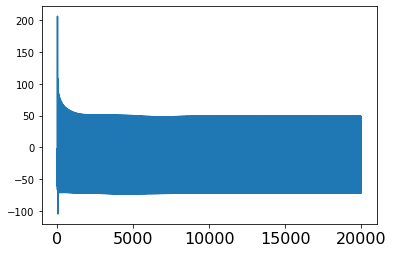

In [90]:
plt.plot(sol.t, sol.y[0])

Text(0.5, 0, 'time')

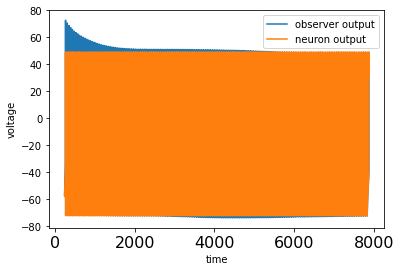

In [91]:
plt.plot(sol.t[1000:30000],sol.y[0][1000:30000],label='observer output')
plt.plot(sol.t[1000:30000],sol.y[cell1.pos_p][1000:30000],label= 'neuron output')
plt.legend()
plt.ylabel('voltage')
plt.xlabel('time')

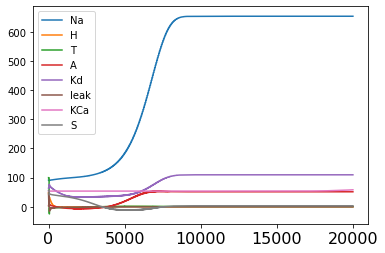

In [92]:
labels=[ 'Na','H','T','A','Kd','leak','KCa','S','syn1','syn2','syn3','syn4']
    
    
    
T_plot=0

for i in range(cell1.num_Theta):
    plt.plot(sol.t[T_plot:],sol.y[cell1.pos_dinamics+i][T_plot:],label=labels[i])
plt.legend()

## Robustness simulations

### 1 Mismatches in time-constant function

#### STG simulation 7 (Voltage input only adaptive observer, estimate only calcium conductances, with mismatches in time-constant functions)

In [42]:
# inintialise STG network with Voltage input only adaptive observer 
net1=random_MOD_mis([0.,1.,1.,1.,0.],True,False) # second argument set to true to include mismatches in time-constant functions
# set hyper parameters for adaptive observer
gamma=10.
alpha=0.001
# set neuromodulation scheme for STG
net1.set_mod(fgS2,fgT2)
# specify parameters to learn (gT and gS in this case)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)
# get initial condition 
X0=inti_cond_net(net1)
# set simulation time
Tfinal=28000.0
tspan=[0.0,Tfinal]
# start simulation and the timer 
start = time.time()
sol1=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 2.38210594e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 1.61128584e+01
 7.71695119e-02]
[-32.52208758]
[5.03580000e+02 9.29811000e-02 3.32014303e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 1.11712019e+01
 7.63508367e-02 2.10839169e-02]
[-97.24152174]
[6.34723000e+02 7.81820000e-02 7.23608575e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 5.17761060e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-8.78946615]
[4.59807000e+02 8.34140000e-02 7.35031669e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 2.43718074e+01
 1.17123333e-01 2.28748603e-02]
[-96.13543873]
[6.16433000e+02 

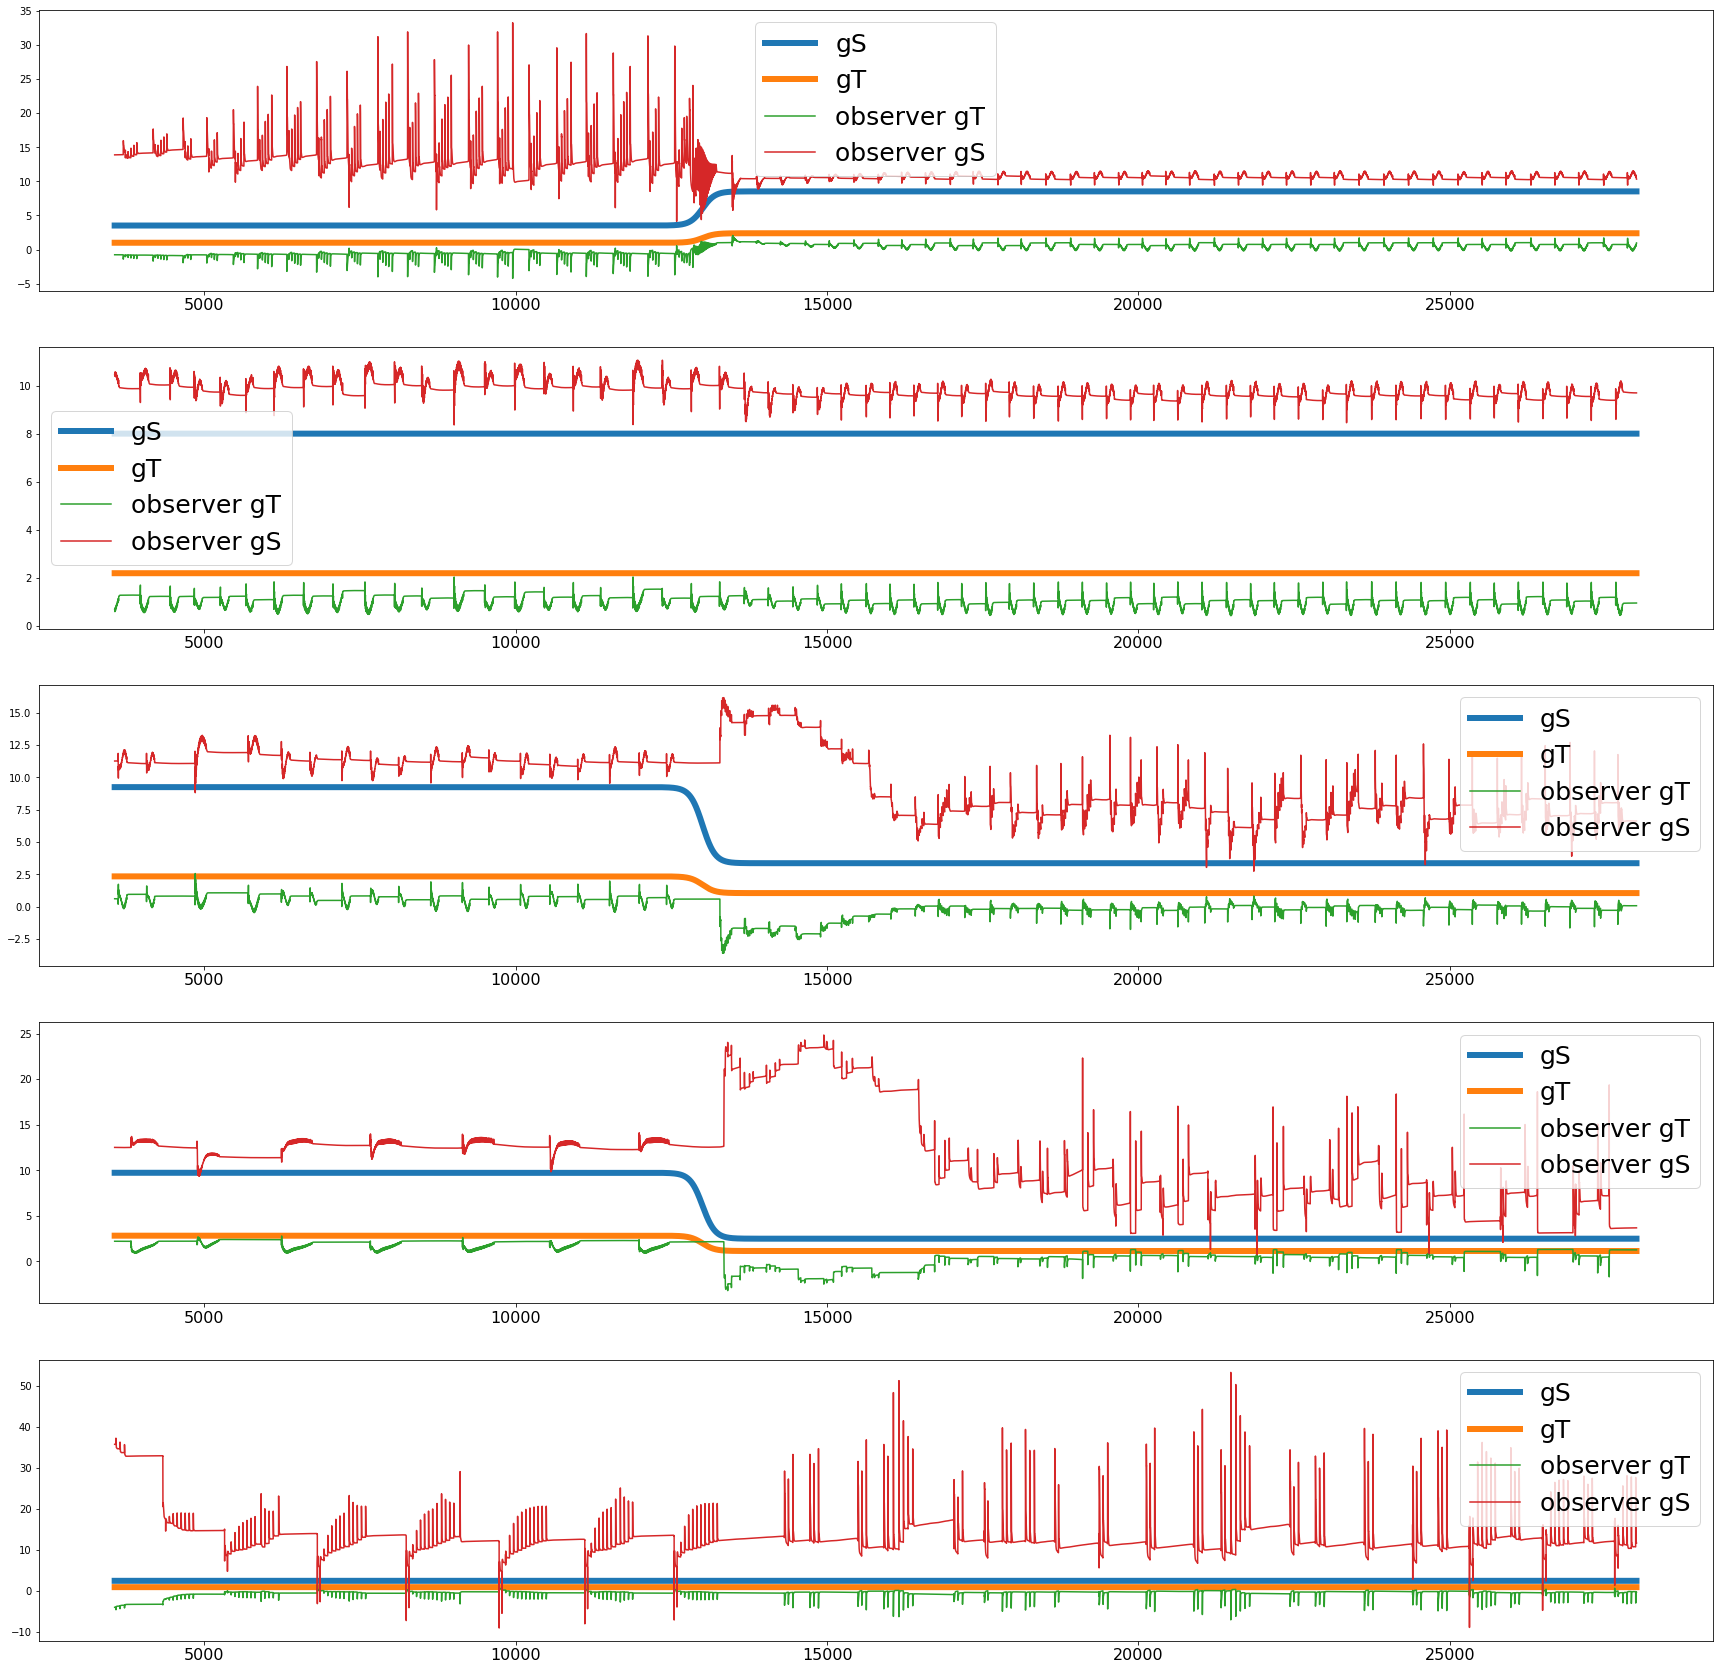

0.9702653484920771
0.948784920518366
0.07275612816855866
1.2699056099215635
-0.24999222965095383


In [62]:
fig=plot_fun2(net1,sol1,fgS2,fgT2)
fig.savefig('robustness_1',bbox_inches='tight')

#### STG simulation 8 (Adaptive observer with voltage and calcium concentration inputs, only estimate gCa, with mismatches in time-constant functions)

In [38]:
net2=random_MOD_mis2([0.,1.,1.,1.,0.],True,False)
gamma=10.
alpha=0.001
net2.set_mod(fgS2,fgT2)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net2.cells[0].set_hyp(gamma,alpha,variable_mask1)
net2.cells[1].set_hyp(gamma,alpha,variable_mask2)
net2.cells[2].set_hyp(gamma,alpha,variable_mask3)
net2.cells[3].set_hyp(gamma,alpha,variable_mask2)
net2.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net(net2)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol2=solve_ivp(net2.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 7.69393536e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 9.37666954e+01
 7.71695119e-02]
[-0.68806366]
[5.03580000e+02 9.29811000e-02 7.01515038e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 5.75514273e+00
 7.63508367e-02 2.10839169e-02]
[-65.09809846]
[6.34723000e+02 7.81820000e-02 7.24565202e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 9.16194750e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-61.2548943]
[4.59807000e+02 8.34140000e-02 6.32475206e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 8.75706486e+01
 1.17123333e-01 2.28748603e-02]
[-14.68776451]
[6

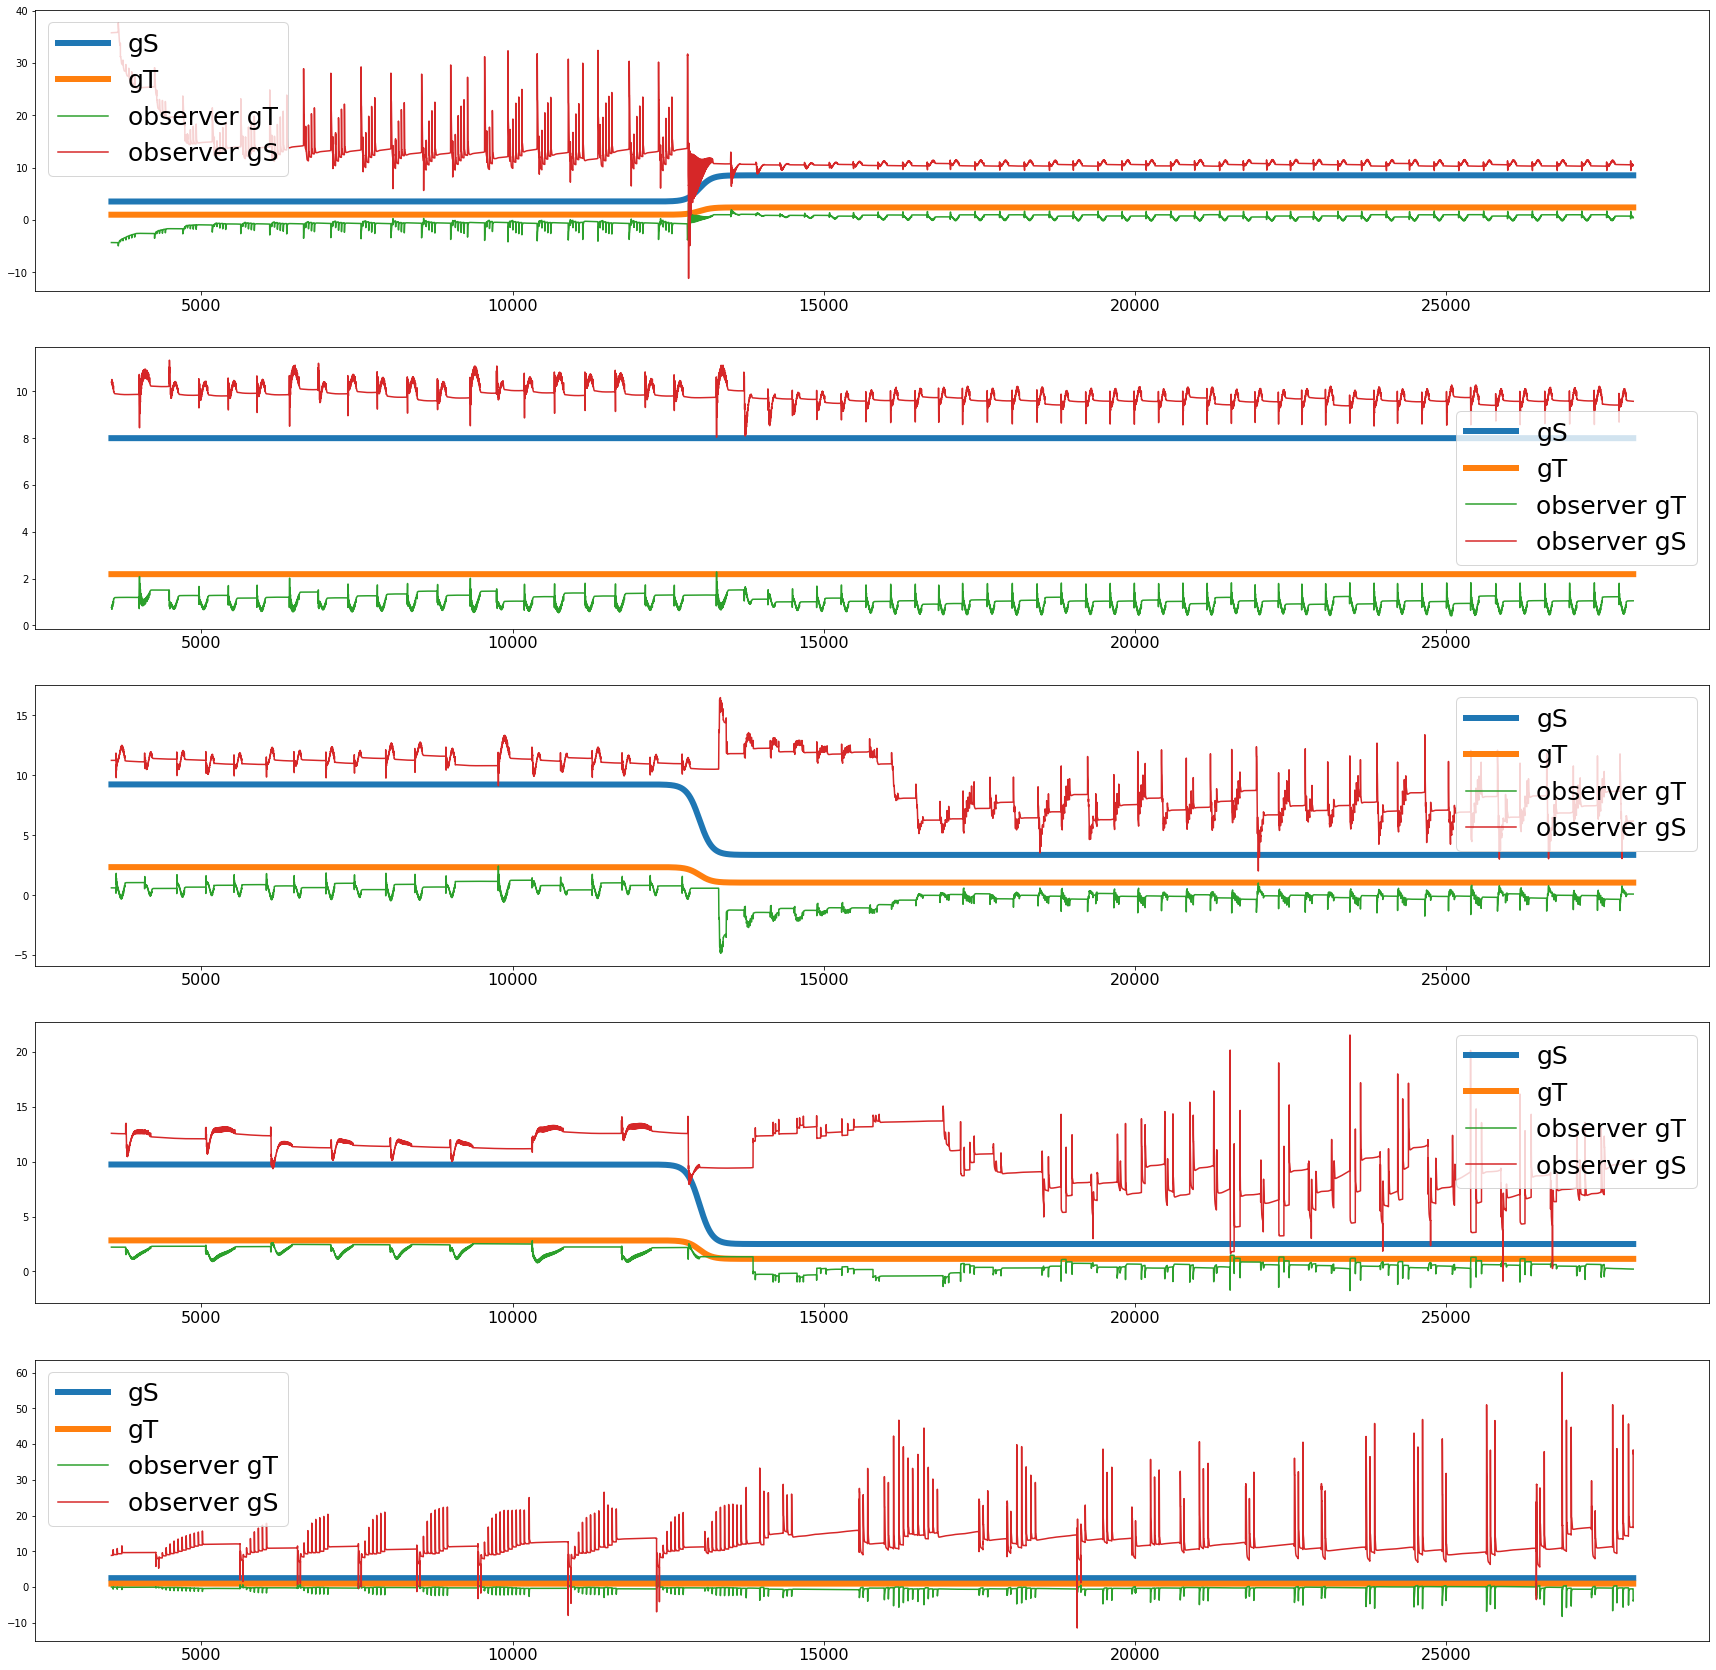

0.47624908731230325
1.0524557543783115
0.09212362684405764
0.2192361384770994
-3.7462493903877494


In [63]:
fig=plot_fun2(net2,sol2,fgS2,fgT2)
fig.savefig('robustness_2',bbox_inches='tight')

#### STG simulation 9 (Adaptive observer minimizing calcium concentration error, only estimate gCa, with mismatches in time-constant functions

In [44]:
# inintialise STG network with Ca based adaptive observer 
net3=random_MOD_mis3([0.,1.,1.,1.,0.],True,False)
gamma=10.
alpha=0.001
net3.set_mod(fgS2,fgT2)
# can only learn gS and gT
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net3.cells[0].set_hyp(gamma,alpha,variable_mask1)
net3.cells[1].set_hyp(gamma,alpha,variable_mask2)
net3.cells[2].set_hyp(gamma,alpha,variable_mask3)
net3.cells[3].set_hyp(gamma,alpha,variable_mask2)
net3.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net(net3)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol3=solve_ivp(net3.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 1.84784459e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 2.93844679e+01
 7.71695119e-02]
[-7.39627365]
[5.03580000e+02 9.29811000e-02 1.60187006e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 4.26862783e+01
 7.63508367e-02 2.10839169e-02]
[-66.23953553]
[6.34723000e+02 7.81820000e-02 2.31569835e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 8.09987914e+00
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-36.72744921]
[4.59807000e+02 8.34140000e-02 8.98334369e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 1.06932299e+01
 1.17123333e-01 2.28748603e-02]
[-29.64701237]
[6.16433000

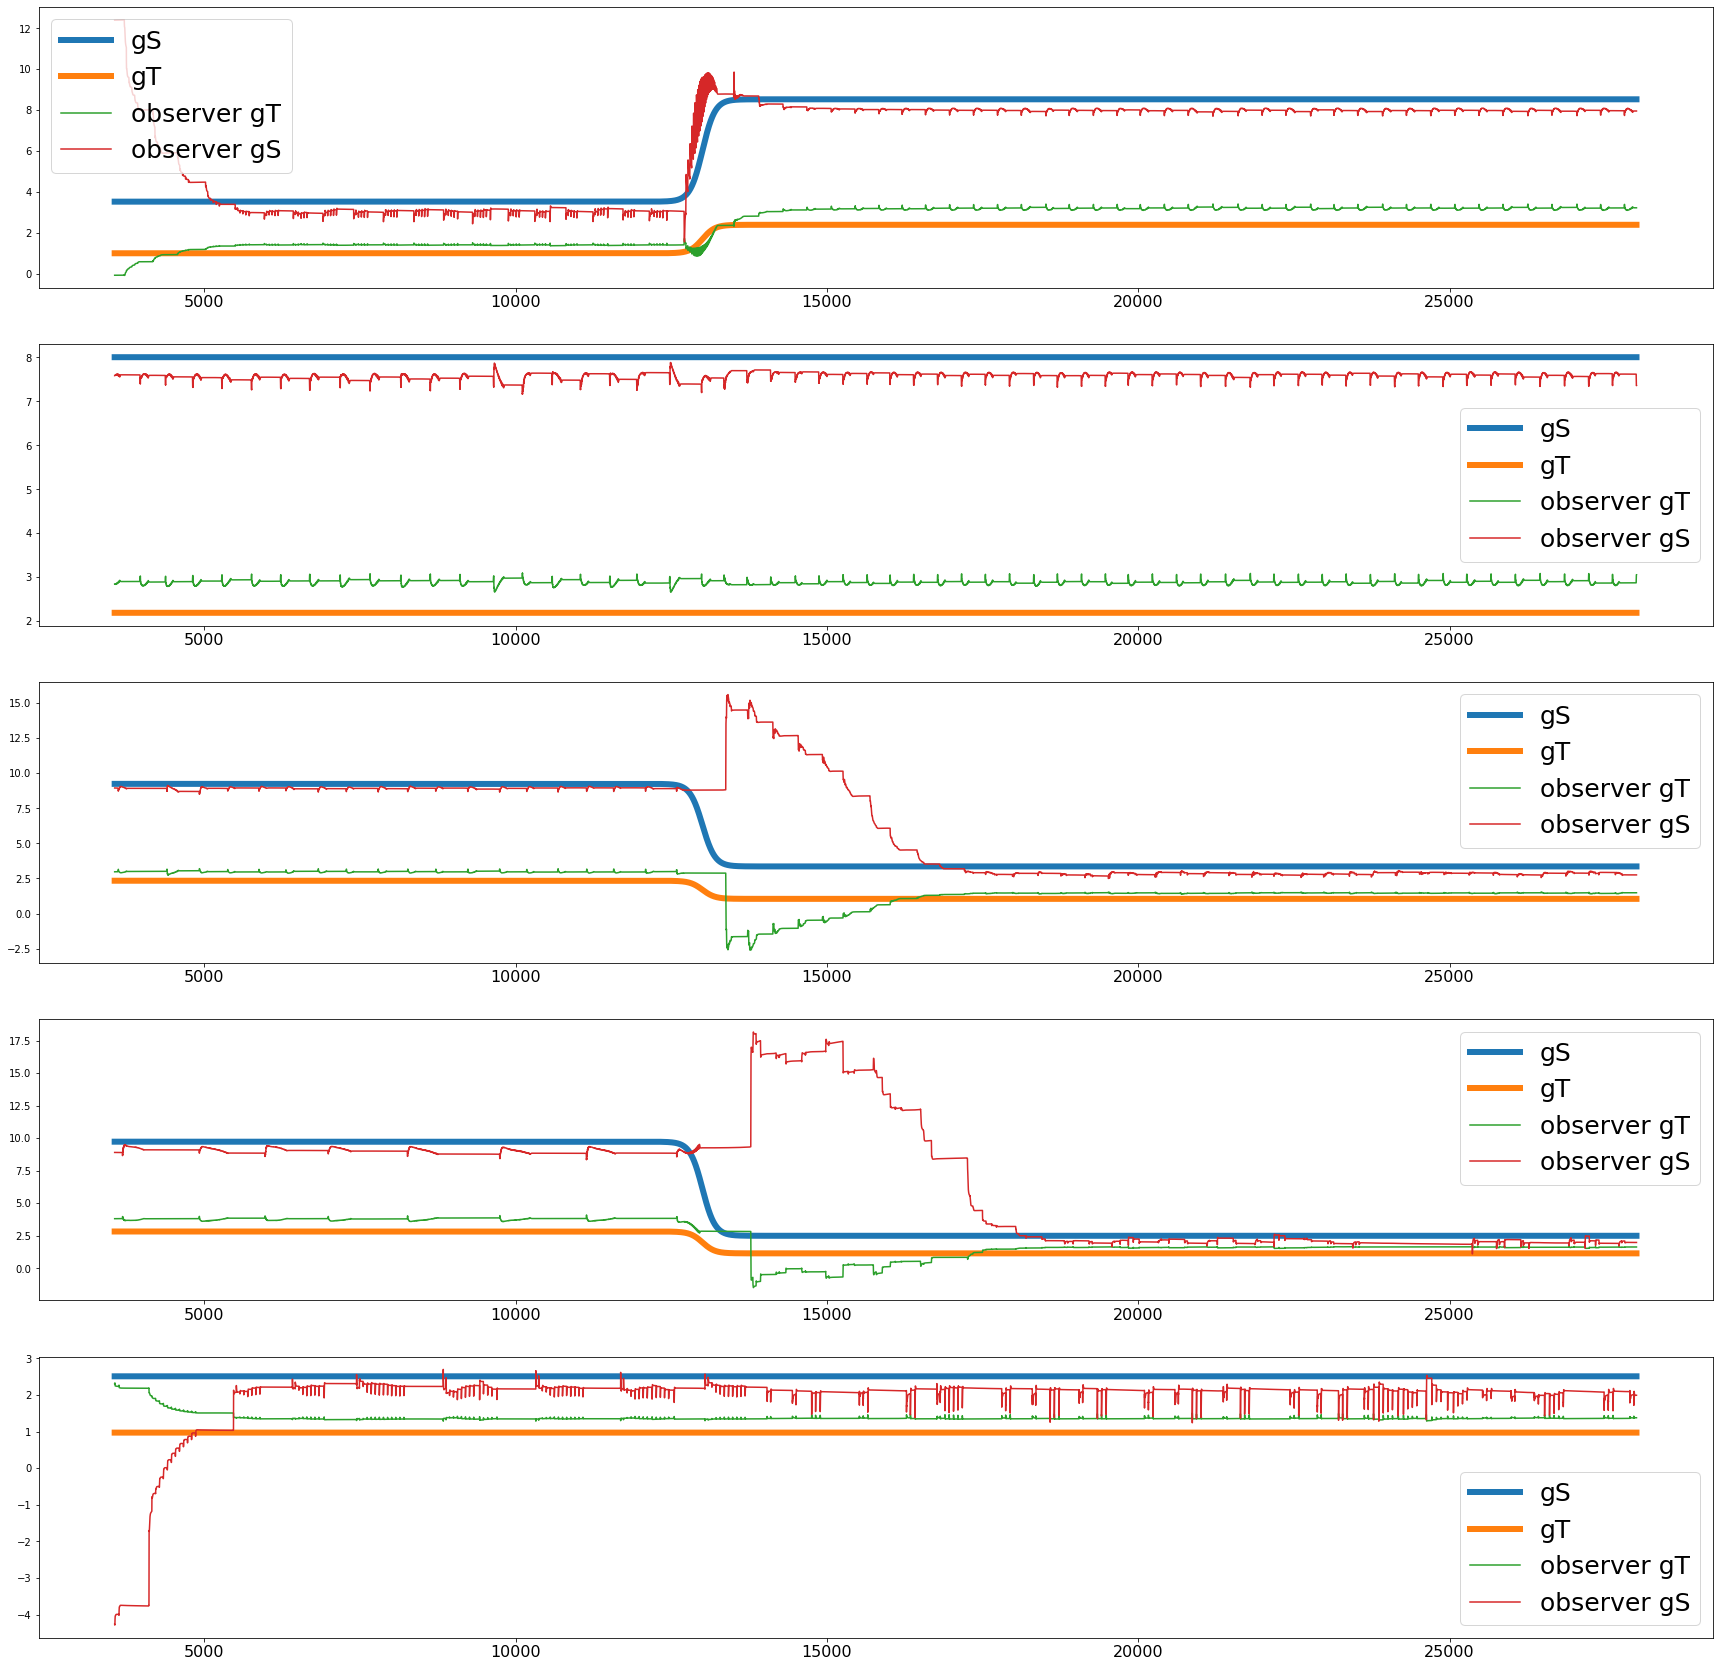

3.217963466901592
3.0588992528179832
1.4841985873084311
1.6383588595590204
1.3774573905304373


In [64]:
fig=plot_fun2(net3,sol3,fgS2,fgT2)
fig.savefig('robustness_3',bbox_inches='tight')

### 2 Mismatches in activation functions

#### STG simulation 10 (Voltage input only adaptive observer, estimate only calcium conductances, with mismatches in activation functions

In [46]:
# inintialise STG network with Voltage input only adaptive observer 
net4=random_MOD_mis([0.,1.,1.,1.,0.],False,True)# third argument set to true to include mismatches in time-constant functions
# set hyper parameters for adaptive observer
gamma=10.
alpha=0.001
# set neuromodulation scheme for STG
net4.set_mod(fgS2,fgT2)
# specify parameters to learn (gT and gS in this case)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net4.cells[0].set_hyp(gamma,alpha,variable_mask1)
net4.cells[1].set_hyp(gamma,alpha,variable_mask2)
net4.cells[2].set_hyp(gamma,alpha,variable_mask3)
net4.cells[3].set_hyp(gamma,alpha,variable_mask2)
net4.cells[4].set_hyp(gamma,alpha,variable_mask1)
# get initial condition 
X0=inti_cond_net(net4)
# set simulation time
Tfinal=28000.0
tspan=[0.0,Tfinal]
# start simulation and the timer 
start = time.time()
sol4=solve_ivp(net4.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 5.50611537e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 4.40378462e+01
 7.71695119e-02]
[-86.75644017]
[5.03580000e+02 9.29811000e-02 7.25118490e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 4.13169250e+01
 7.63508367e-02 2.10839169e-02]
[-36.77766421]
[6.34723000e+02 7.81820000e-02 7.37829426e+00 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 3.47433342e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-35.81401557]
[4.59807000e+02 8.34140000e-02 7.24754554e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 7.56250247e+01
 1.17123333e-01 2.28748603e-02]
[-51.88103372]
[6.16433000e+02

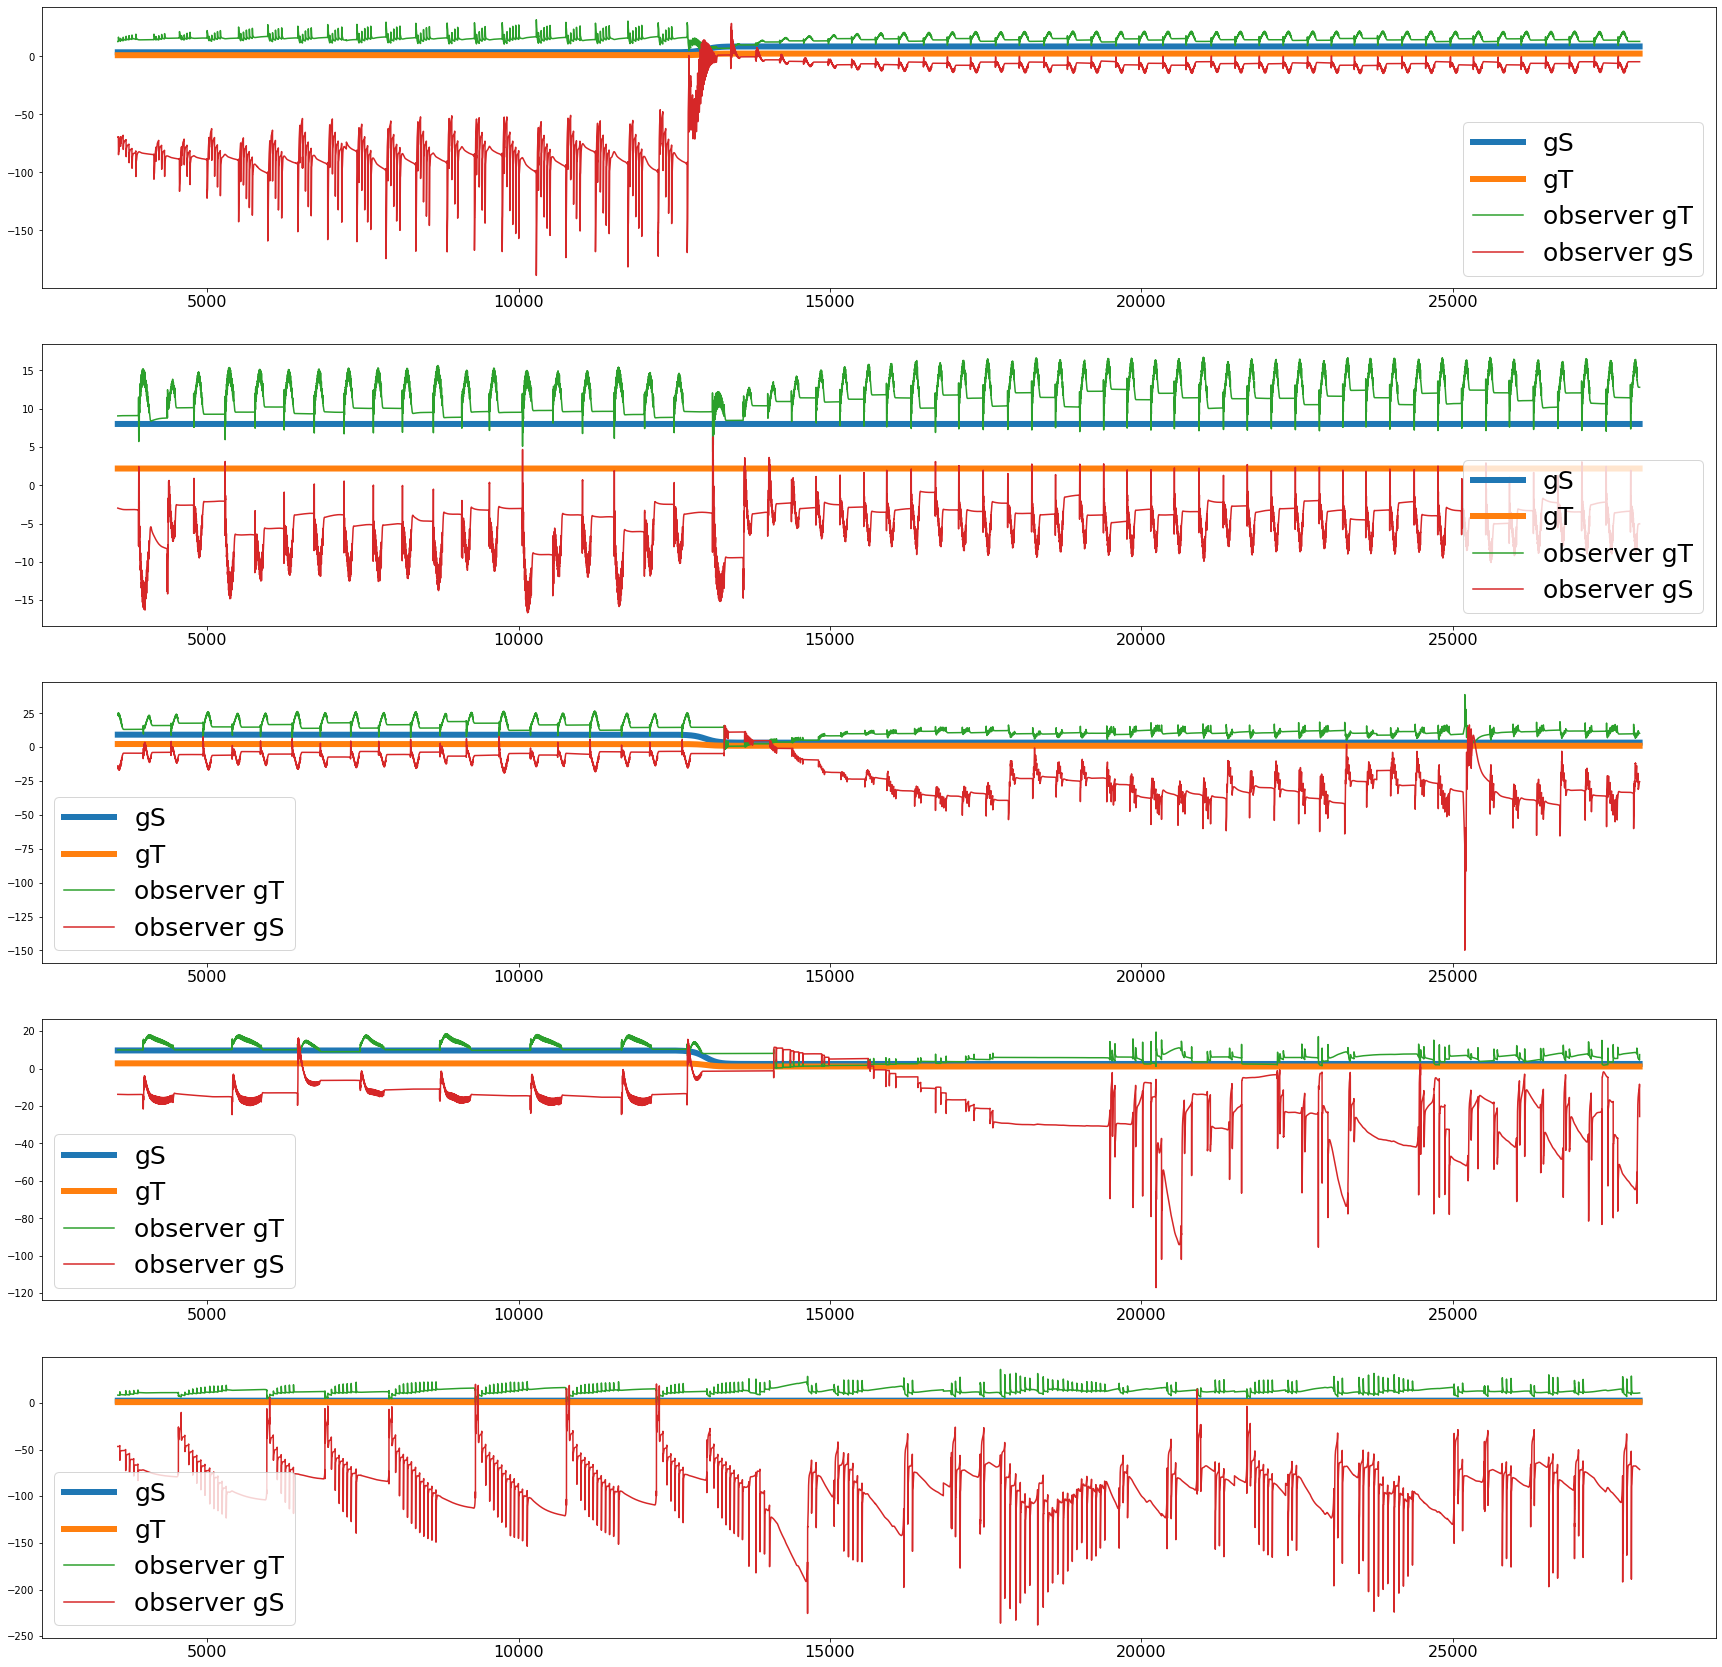

12.860802625785025
12.792023798587863
10.186745746370997
7.508699951538786
10.803414341944496


In [65]:
fig=plot_fun2(net4,sol4,fgS2,fgT2)
fig.savefig('robustness_4',bbox_inches='tight')

#### STG simulation 11 (Adaptive observer with voltage and calcium concentration inputs, only estimate gCa, with mismatches in activation functions)

In [48]:
net5=random_MOD_mis2([0.,1.,1.,1.,0.],False,True)
gamma=10.
alpha=0.001
net5.set_mod(fgS2,fgT2)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net5.cells[0].set_hyp(gamma,alpha,variable_mask1)
net5.cells[1].set_hyp(gamma,alpha,variable_mask2)
net5.cells[2].set_hyp(gamma,alpha,variable_mask3)
net5.cells[3].set_hyp(gamma,alpha,variable_mask2)
net5.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net(net5)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol5=solve_ivp(net5.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
V_Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 1.97449535e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 3.19646675e+01
 7.71695119e-02]
[-53.67100835]
[5.03580000e+02 9.29811000e-02 6.87846558e+00 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.84537368e+01
 7.63508367e-02 2.10839169e-02]
[-57.28019987]
[6.34723000e+02 7.81820000e-02 4.53257164e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 3.29430243e+00
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-73.60373634]
[4.59807000e+02 8.34140000e-02 6.41688194e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 6.86182121e+01
 1.17123333e-01 2.28748603e-02]
[-94.07706463]


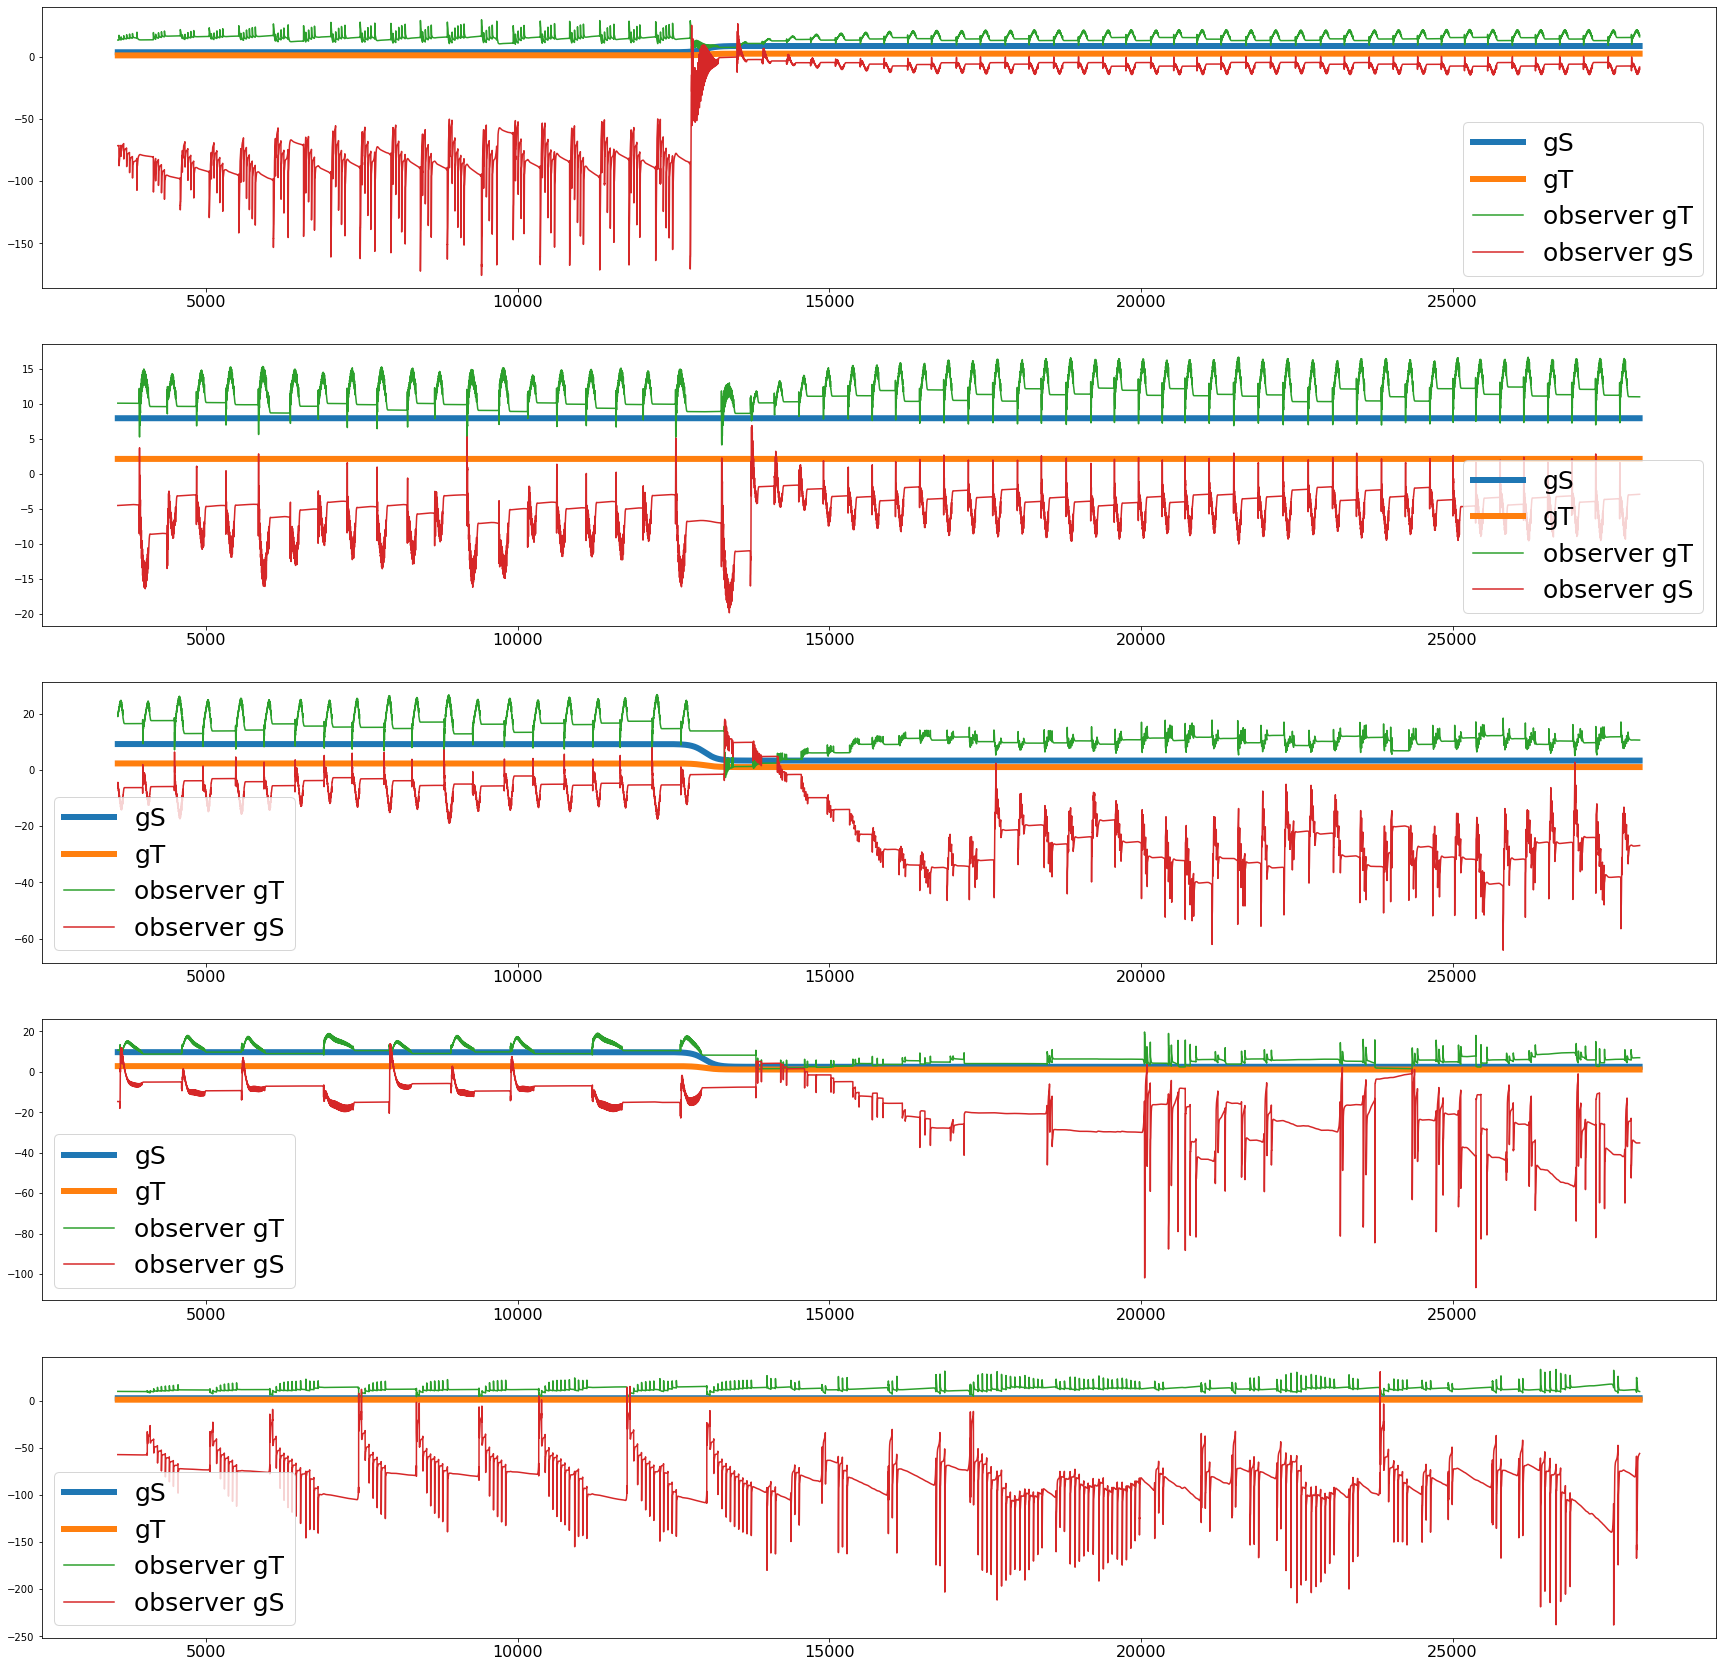

15.860998194902926
11.064965794165115
10.658297488515656
6.993553566165708
9.619671645434874


In [66]:
fig=plot_fun2(net5,sol5,fgS2,fgT2)
fig.savefig('robustness_5',bbox_inches='tight')

#### STG simulation 12 (Ca+ based adaptive observer, only estimate gCa, with mismatches in time-constant functions)

In [51]:
net6=random_MOD_mis3([0.,1.,1.,1.,0.],False,True)
gamma=10.
alpha=0.001
net6.set_mod(fgS2,fgT2)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net6.cells[0].set_hyp(gamma,alpha,variable_mask1)
net6.cells[1].set_hyp(gamma,alpha,variable_mask2)
net6.cells[2].set_hyp(gamma,alpha,variable_mask3)
net6.cells[3].set_hyp(gamma,alpha,variable_mask2)
net6.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net(net6)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol6=solve_ivp(net6.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 6.63395012e+00 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 4.84773767e+01
 7.71695119e-02]
[-66.48871263]
[5.03580000e+02 9.29811000e-02 2.89374638e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 2.01081949e+01
 7.63508367e-02 2.10839169e-02]
[-48.12423444]
[6.34723000e+02 7.81820000e-02 9.34338132e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 7.97594007e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-14.20681589]
[4.59807000e+02 8.34140000e-02 4.17669617e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 9.89010148e+01
 1.17123333e-01 2.28748603e-02]
[-15.98485647]
[6.1643300

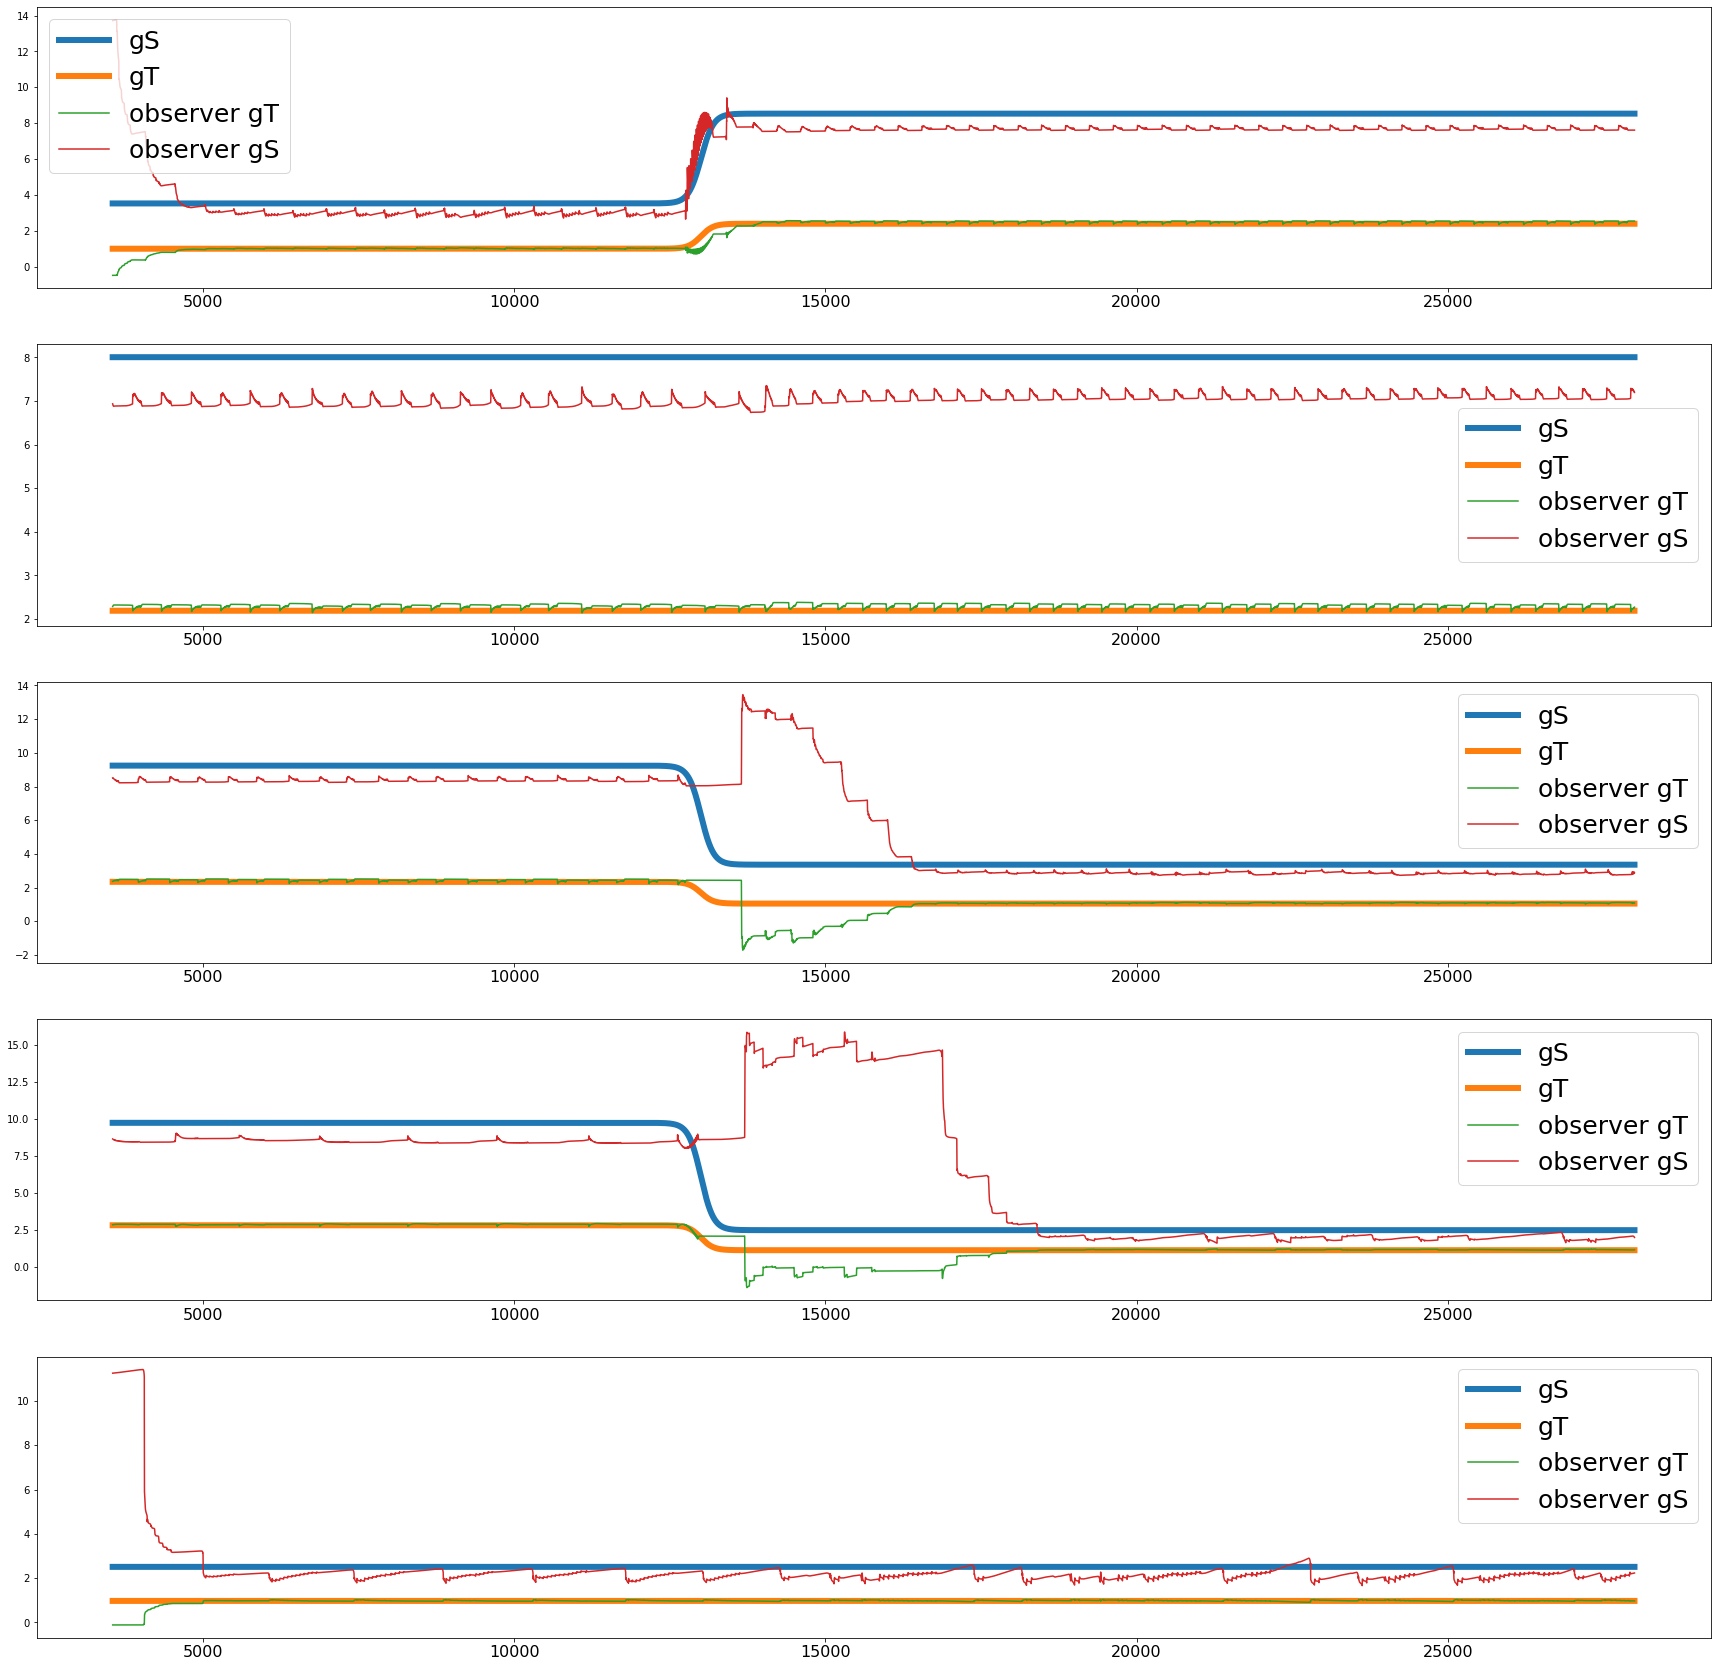

2.5354624306973403
2.2712613808356985
1.0852173406994432
1.1769659363193723
0.9727457052313633


In [67]:
fig=plot_fun2(net6,sol6,fgS2,fgT2)
fig.savefig('robustness_6',bbox_inches='tight')

#### STG simulation 13 (Ca+ based adaptive observer, only estimate gCa, with mismatches in time-constant functions, activation functions and maximum conductances)

In [53]:
net_t2=random_MOD_mis3([0.,1.,1.,1.,0.],True,True)# second and third argument set to true to include both mismatches
gamma=10.
alpha=0.001
net_t2.set_mod(fgS2,fgT2)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net_t2.cells[0].set_hyp(gamma,alpha,variable_mask1)
net_t2.cells[1].set_hyp(gamma,alpha,variable_mask2)
net_t2.cells[2].set_hyp(gamma,alpha,variable_mask3)
net_t2.cells[3].set_hyp(gamma,alpha,variable_mask2)
net_t2.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net_mis(net_t2)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol_t2=solve_ivp(net_t2.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.60073738e+02 1.09156713e-01 1.60431242e+01 5.01970260e+01
 1.14966473e+02 9.91941516e-03 6.82849060e+01 1.10366578e+01
 8.27740436e-02]
[-2.26853094]
[5.25302358e+02 9.39768648e-02 4.96662780e+01 5.64036539e+01
 7.87027206e+01 1.07592268e-02 4.87979579e+01 3.07855997e+00
 7.56641421e-02 1.95988853e-02]
[-14.94943932]
[5.98602001e+02 7.49903907e-02 9.52896724e+01 4.19240494e+01
 7.65449773e+01 9.80364141e-03 6.37343785e+01 5.39408860e+01
 8.43405007e-02 8.98052969e-02 2.18445482e-02 2.24764407e-02]
[-46.5310632]
[4.97885623e+02 9.02078878e-02 5.70265352e+01 5.41425883e+01
 9.87192409e+01 1.08468068e-02 5.03831670e+01 8.80792863e+01
 1.14155460e-01 2.08566202e-02]
[-49.65848724]
[5.69581695e

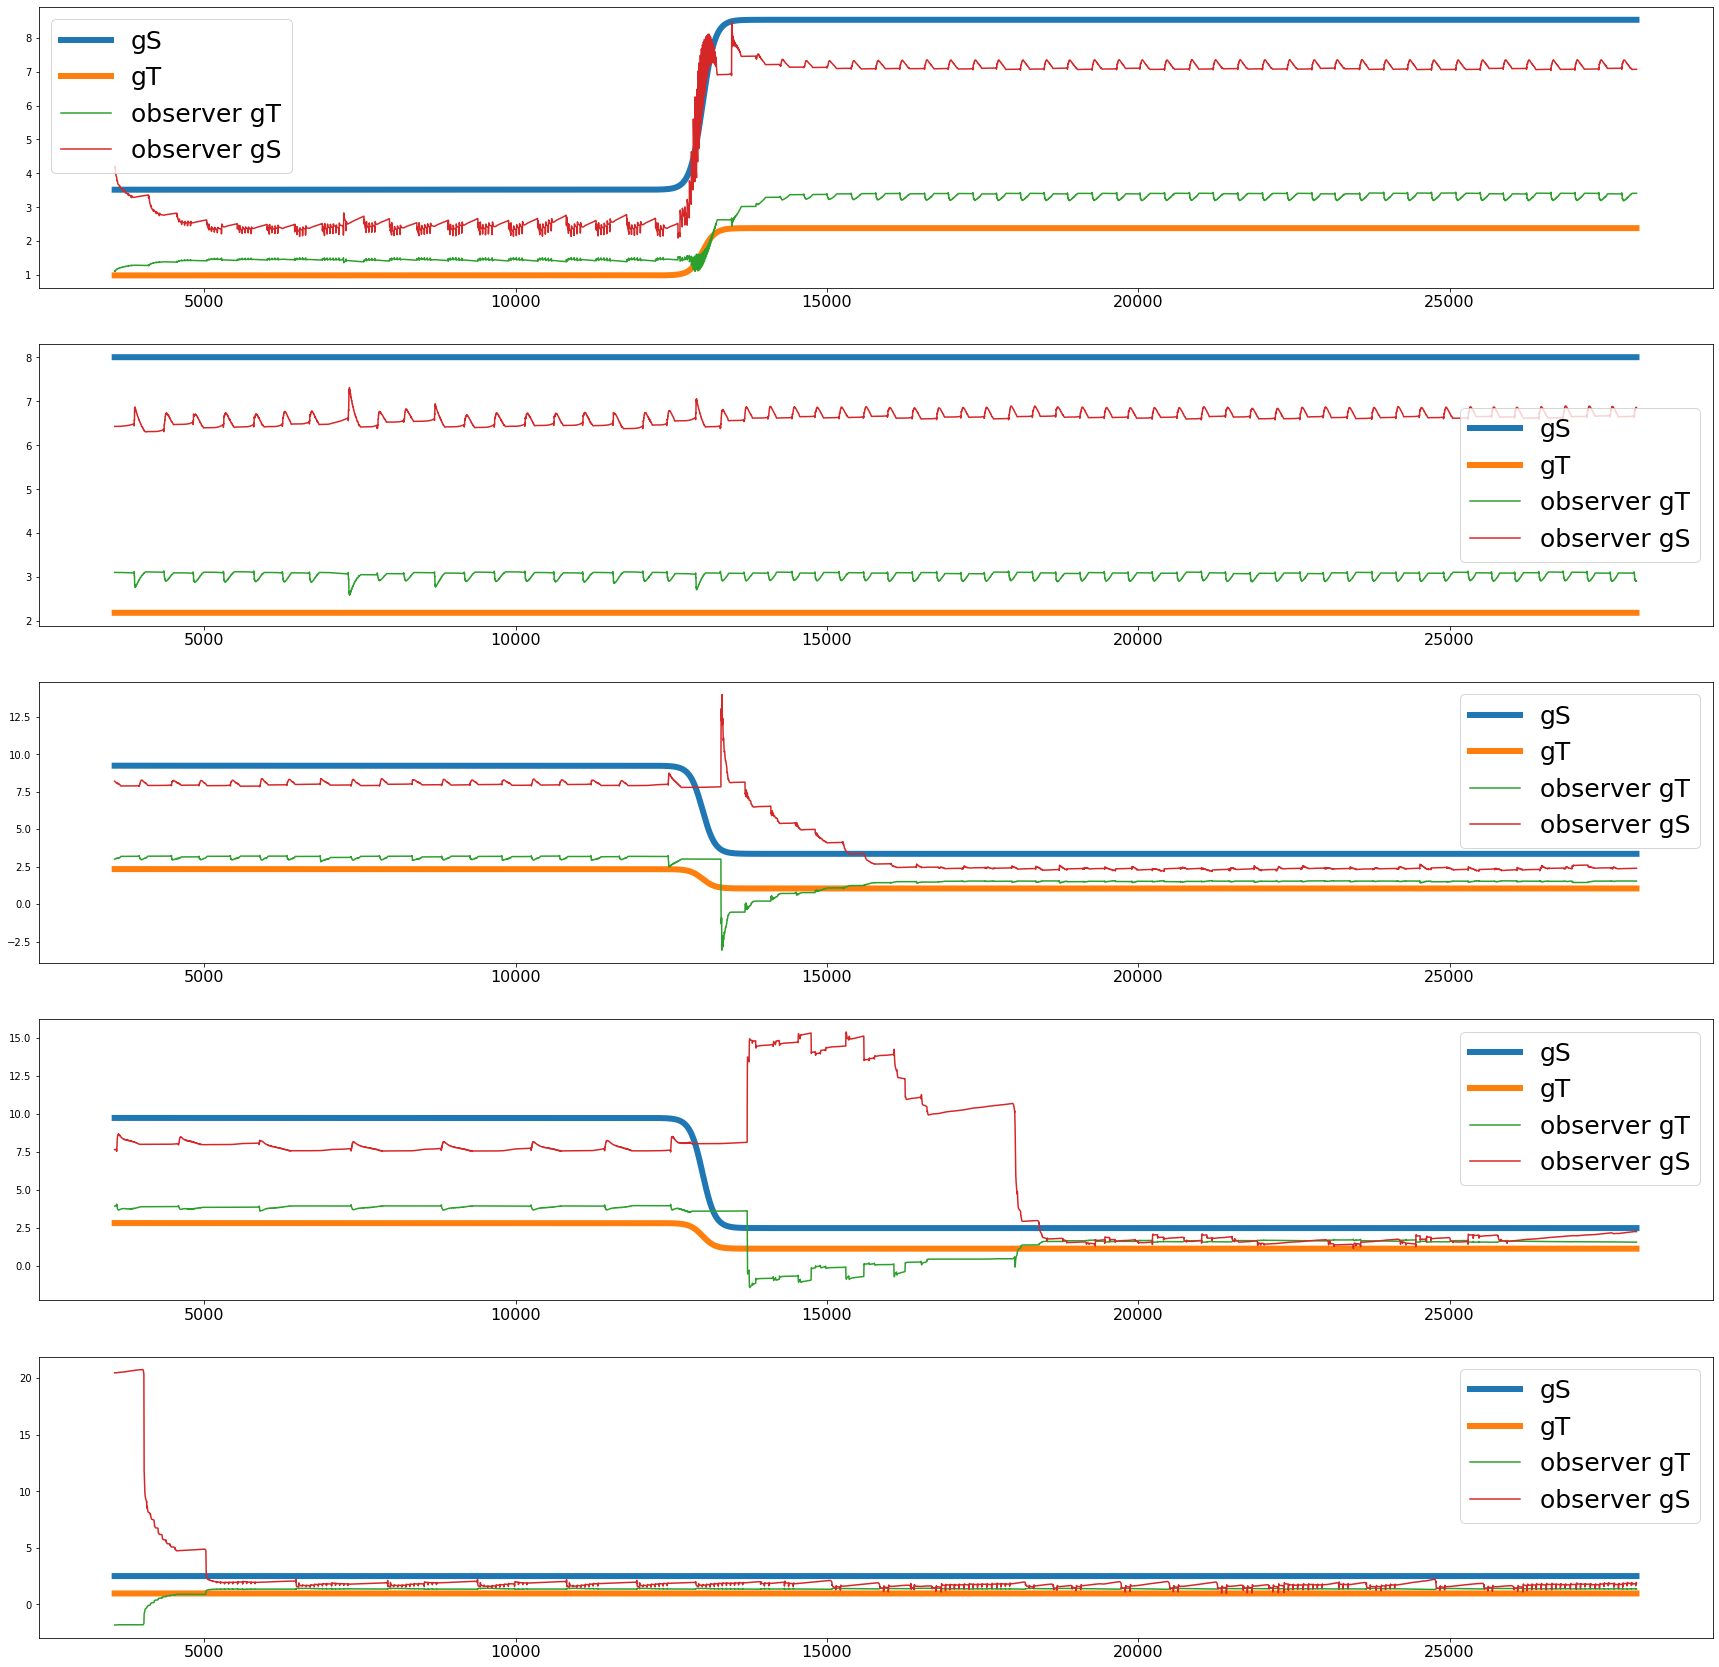

3.4125008538804544
2.9114766004040162
1.5442005013605118
1.575318312547713
1.3673094157629195


In [68]:
fig=plot_fun2(net_t2,sol_t2,fgS2,fgT2)
fig.savefig('robustness_7',bbox_inches='tight')

In [5]:
net_t3=random_MOD_mis3([0.,1.,1.,1.,0.],True,True)# second and third argument set to true to include both mismatches
gamma=10.
alpha=0.001
net_t3.set_mod(fgS2,fgT2)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net_t3.cells[0].set_hyp(gamma,alpha,variable_mask1)
net_t3.cells[1].set_hyp(gamma,alpha,variable_mask2)
net_t3.cells[2].set_hyp(gamma,alpha,variable_mask3)
net_t3.cells[3].set_hyp(gamma,alpha,variable_mask2)
net_t3.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=inti_cond_net_0(net_t3)
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol_t3=solve_ivp(net_t3.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
[1. 1. 1. 1. 1. 1.]
num_Theta 8
Ca
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[ 0.          0.         82.10436468  0.          0.          0.
  0.         73.14345805  0.        ]
[-37.80599212]
[ 0.          0.         35.72870116  0.          0.          0.
  0.         47.70696011  0.          0.        ]
[-64.87551382]
[ 0.          0.         59.67553095  0.          0.          0.
  0.         66.70155776  0.          0.          0.          0.        ]
[-9.02247181]
[ 0.          0.         12.33366956  0.          0.          0.
  0.          5.33792081  0.          0.        ]
[-66.60785779]
[ 0.          0.         38.80212916  0.          0.          0.
  0.         60.63400728  0.        ]
[-83.88272194]


<string>:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))


Elapsed (with compilation) = 500.19097328186035


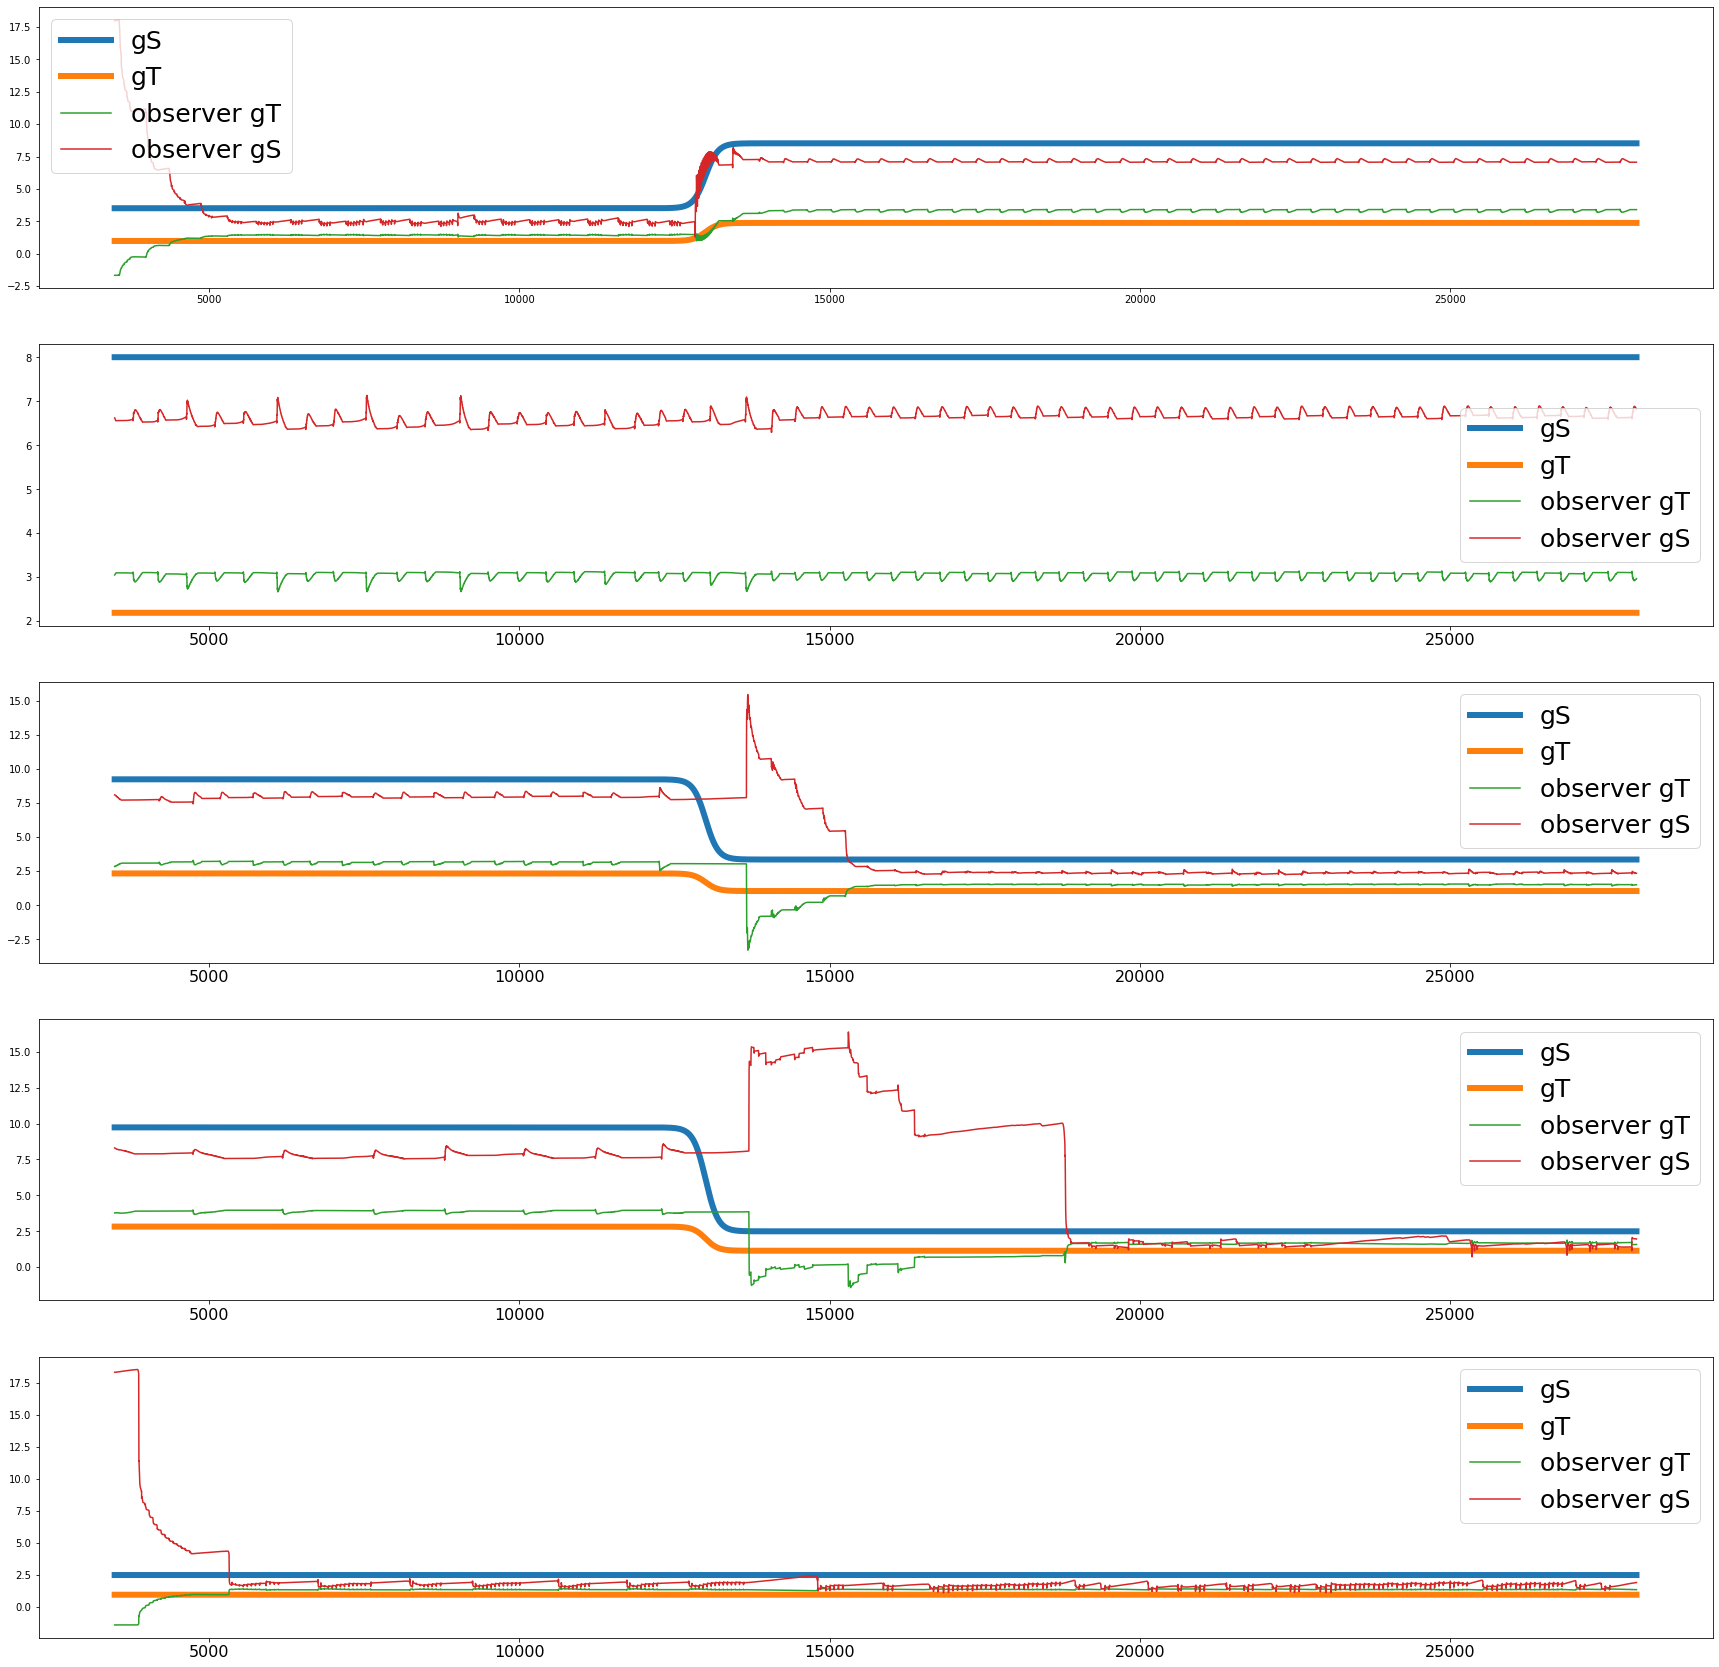

3.4120023487890068
2.9679726966070326
1.510069492056547
1.585498540157927
1.365879771330213


In [7]:
fig=plot_fun2(net_t3,sol_t3,fgS2,fgT2)
fig.savefig('robustness_8',bbox_inches='tight')